In [38]:
import numpy
import numba
import numpy as np
import scipy.interpolate as interpolate
from math import factorial



#I present Maximal Extraction Intrinsic Time-Scale Decomposition.
#This model is intended to perform maximum extractions, and then sort
#the output by entropy. Noise is generally the very last item-
#the trends from 0:-1 are increasing entropy and frequency.



# The following functions are implemented/stolen here:
# numba accelerated cubic interpolation(except the spline construction, splrep, not sure about time cost there
# two different findpeaks functions: not sure which to use
# the matlab style version will always provide rotations which meet frei-osorio "proper rotation" criteria.
# however, these rotations are often not orthonormal and the non-"proper rotation" findpeaks will return
# rotations with extrema translated below and above 0, but which better fit the data.
# I am going to personally go with the second findpeak, but if you are interested in statistically correct answers,
# just switch it out for matlab_detect_peaks

# ensemble ITD "        Hu, Aijun; Yan, Xiaoan; Xiang, Ling  (2015).
# A new wind turbine fault diagnosis method based on ensemble intrinsic time-scale decomposition
# and WPT-fractal dimension. Renewable Energy, 83(), 767–778.
# doi:10.1016/j.renene.2015.04.063 
# is partially implemented here.
# EITD-MP "Wang, Xiaoling; Ling, Bingo Wing-Kuen (2019).
# Underlying Trend Extraction via Joint Ensemble Intrinsic Timescale Decomposition Algorithm and Matching Pursuit Approach.
# Circuits, Systems, and Signal Processing, (), –. doi:10.1007/s00034-019-01069-2
# https://sci-hub.hkvisa.net/10.1016/j.renene.2015.04.063#
# https://sci-hub.hkvisa.net/10.1007/s00034-019-01069-2
#

# recommendations to improve ITD are also implemented here. In particular:
# mirroring? I think i'm doing it right? extrema
# cubic spline interpolation instead of affine smoothing transformation for baseline interpolation
# akima interpolation also gave interesting results, more like affine, perhaps better
# RMS of PRC calculations
# if i understand the paper correctly, omega = the square root of the mean square of ( current rotation - the RMS of the signal)
# the omega for each should be stored, and then the coefficients with the highest omega selected.
# if i understand right, also, a variable is set, let's say b, value not given in the paper
# and then the sum of the rotation is taken. when the sum of 0.005 * the rotation  < b < the sum of 0.05* the rotation,
# the EITD authors considered it decomposed.  #it's also possible to determine how 'proper" a rotation is by orthonormality.

# Adaptive carrier fringe pattern enhancement for
# wavelet transform profilometry through modifying
# intrinsic time-scale decomposition
# Hanxiao Wang,1 Yinghao Miao,1 Hailu Yang,1 Zhoujing Ye,1 AND Linbing Wang2,3,
# proposed MITD in 2020:
# MITD proposes adding white noise with the same deviation but opposite polarity to two copies of S.
# this can be futher increased to multiple pairs.
# each modified signal copy is decomposed using cubic interpolation(as we have here)
# where each of the PRC's are added together with their opposite twin, same for the residual.
# in the case of an ITD instance generating MORE PRC's than the other, MITD proposes padding with PRC's of 0s to reach
# equal copy counts.
# In theory, this could be applied to EITD.
# the decomposition is quite clean and looks good, and doesn't add a huge amount of overhead.
# The reconstruction error is < 10-16 which is as good as numpy.sum can resolve or better.

# then, MITD proposes WPE measurement and selection of PRC based on WPE, with low WPE = less likely to be noise.
# EITD proposed measuring omega and selecting for high omega.
# EITD-MP proposes matching persuit with binary search.

# then, MITD proposes grey correlation and fuzzy similarity.
# EITD proposes wavelet transforms.

# ITD -> Selection -> Transform/Correlate -> extract

# WPE = weighted-permutation entropy. it is implemented here copied from pyEntropy
# it can be used with weighted_permutation_entropy(x), assuming MITD authors didn't intend a different kind of entropy.
# they measure it between 0 and 1 in most cases, which may mean that the normalization=True must be enabled.
# noise is considered to be WPE above 0.6.
# https://github.com/rsarai/grey-relational-analysis/blob/master/Gait%20and%20Grey%20Methods.ipynb its possible
# that some of te code here could be used to implement the grey fuzzy analysis


# all summed up, here in this `paper` i propose to implement MEITD:
# modified Ensemble Intrinsic Decomposition, where each time a rotation is to be repeatedly decomposed,
# we add noise to it before decomposing and perform the paired decomposition.
# this is only a theoretical possibility atm.


def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T


def util_rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def weighted_permutation_entropy(time_series, order=3, normalize=False):
    """Calculate the Weighted Permutation Entropy.
    Weighted permutation entropy is based on the regular permutation entropy,
    but puts additional weight on those windows that show a high variability
    in the initial time series.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Weighted Permutation Entropy
    References
    ----------
    .. [1] Bilal Fadlallah et al. Weighted-permutation entropy: A complexity
    measure for time series incorporating amplitude information
    https://link.aps.org/accepted/10.1103/PhysRevE.87.022911
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations

    embedded = _embed(x, order=order)
    sorted_idx = embedded.argsort(kind='quicksort')
    weights = np.var(util_rolling_window(x, order), 1)
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    mapping = {}
    for i in np.unique(hashval):
        mapping[i] = np.where(hashval == i)[0]
    weighted_counts = dict.fromkeys(mapping)
    for k, v in mapping.items():
        weighted_count = 0
        for i in v:
            weighted_count += weights[i]
        weighted_counts[k] = weighted_count
    # Associate unique integer to each permutations
    # Return the counts
    # Use np.true_divide for Python 2 compatibility
    weighted_counts_array = np.array(list(weighted_counts.values()))
    p = np.true_divide(weighted_counts_array, weighted_counts_array.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def custom_splrep(x, y, k=3):
    """
    Custom wrap of scipy's splrep for calculating spline coefficients,
    which also check if the data is equispaced.

    """

    # Check if x is equispaced
    x_diff = np.diff(x)
    equi_spaced = all(np.round(x_diff, 5) == np.round(x_diff[0], 5))
    dx = x_diff[0]

    # Calculate knots & coefficients (cubic spline by default)
    t, c, k = interpolate.splrep(x, y, k=k)

    return (t, c, k, equi_spaced, dx)


@numba.njit(cache=True)
def numba_splev(x, coeff):
    """
    Custom implementation of scipy's splev for spline interpolation,
    with additional section for faster search of knot interval, if knots are equispaced.
    Spline is extrapolated from the end spans for points not in the support.

    """
    t, c, k, equi_spaced, dx = coeff

    t0 = t[0]

    n = t.size
    m = x.size

    k1 = k + 1
    k2 = k1 + 1
    nk1 = n - k1

    l = k1
    l1 = l + 1

    y = np.zeros(m)

    h = np.zeros(20)
    hh = np.zeros(19)

    for i in range(m):

        # fetch a new x-value arg
        arg = x[i]

        # search for knot interval t[l] <= arg <= t[l+1]
        if (equi_spaced):
            l = int((arg - t0) / dx) + k
            l = min(max(l, k1), nk1)
        else:
            while not ((arg >= t[l - 1]) or (l1 == k2)):
                l1 = l
                l = l - 1
            while not ((arg < t[l1 - 1]) or (l == nk1)):
                l = l1
                l1 = l + 1

        # evaluate the non-zero b-splines at arg.
        h[:] = 0.0
        hh[:] = 0.0

        h[0] = 1.0

        for j in range(k):

            for ll in range(j + 1):
                hh[ll] = h[ll]
            h[0] = 0.0

            for ll in range(j + 1):
                li = l + ll
                lj = li - j - 1
                if (t[li] != t[lj]):
                    f = hh[ll] / (t[li] - t[lj])
                    h[ll] += f * (t[li] - arg)
                    h[ll + 1] = f * (arg - t[lj])
                else:
                    h[ll + 1] = 0.0
                    break

        sp = 0.0
        ll = l - 1 - k1

        for j in range(k1):
            ll += 1
            sp += c[ll] * h[j]
        y[i] = sp

    return y


@numba.njit(numba.boolean[:](numba.int64[:], numba.int64[:]), parallel=True)
def isin(a, b):
    out = numpy.empty(a.shape[0], dtype=numba.boolean)
    b = set(b)
    for i in numba.prange(a.shape[0]):
        if a[i] in b:
            out[i] = True
        else:
            out[i] = False
    return out


@numba.njit(numba.int64[:](numba.float64[:]))
def matlab_detect_peaks(x: list[float]):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if len(x) < 3:
        return numpy.empty(1, numpy.int64)
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = numpy.where(numpy.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size != 0:
        x[indnan] = numpy.inf
        dx[numpy.where(numpy.isnan(dx))[0]] = numpy.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]  # hacky solution because numba does not like hstack tuple arrays
    # numpy.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]

    ind = numpy.unique(numpy.where((vil <= 0) & (vix > 0))[0])

    rx = numpy.append(dx, [dx[-1] + 1])
    arr_diff = numpy.diff(rx)
    res_mask = arr_diff == 0
    arr_diff_zero_right = numpy.nonzero(res_mask)[0] + 1
    res_mask[arr_diff_zero_right] = True
    repeating = numpy.nonzero(res_mask)[0]
    rset = set(repeating)
    if len(repeating) != 0:  # if there are repeating elements:
        for each in range(len(ind)):
            if ind[each] in rset:  # is this a repeating index?
                ind[each] = numpy.argmax(dx[ind[each]:] != dx[ind[each]]) - 1  # if so, set it to the rightmost value.
    # this adjustment is intended to implement "rightmost value of flat peaks" efficiently.
    # https://arxiv.org/pdf/1404.3827v1.pdf page 3 - always take right-most sample

    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = numpy.unique(numpy.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]

    # eliminate redundant values
    return numpy.unique(ind)


@numba.njit(numba.int64[:](numba.float64[:]))
def detect_peaks(x: list[numpy.float64]):
    # warning: this is not a good, proper, peak-finding method.
    # all this does is determine extrema location and counts for ITD.
    # if you want a matlab findpeaks, use Marcos Duarte's findpeaks.
    # if you want a good general purpose peakfinding method, use a guassian method.

    f = x.copy()
    locmax = numpy.zeros_like(f)

    for i in range(1, len(x) - 1):  # don't consider an end value a peak.
        if (f[i] >= f[i - 1]):
            if (f[i] > f[i + 1]):
                if (f[i] > 0):
                    locmax[i] = 1  # strictly rising peaks
    return numpy.where(locmax == 1)[0]


@numba.jit(cache=True)
def baseline_knot_estimation(baseline_knots: list[numpy.float64], x: list[numpy.float64],
                             extrema_indices: list[numpy.float64]):
    alpha = 0.5
    for k in range(1, len(extrema_indices) - 1):
        baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] \
                                     + ((extrema_indices[k] - extrema_indices[k - 1]) \
                                        / (extrema_indices[k + 1] - extrema_indices[k - 1])) \
                                     * (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) \
                            + (alpha * x[extrema_indices[k]])

    return baseline_knots[:]



def itd_baseline_extract(data: list[numpy.float64]) -> [numpy.ndarray, numpy.ndarray]:
    proper_rotation = 0
    x = numpy.asarray(data, dtype=numpy.float64)
    rotation = numpy.zeros_like(x)
    baseline_new = numpy.zeros_like(x)

    idx_max = numpy.asarray(detect_peaks(x))
    idx_min = numpy.asarray(detect_peaks(-x))

    num_extrema = idx_min.size + idx_max.size
    #if num_extrema < 5:
     #   print("decomposition failed in ITD_baseline_extract")
     #   return x, baseline_new, 0
    extremabuffersize = num_extrema + 2
    extrema_indices = numpy.zeros(extremabuffersize, dtype=numpy.int64)
    extrema_indices[1:-1] = numpy.sort(numpy.unique(numpy.hstack((idx_max, idx_min))))
    extrema_indices[-1] = len(x) - 1

    baseline_knots = numpy.zeros(len(extrema_indices))

    padded = numpy.pad(x, 1, mode='reflect', reflect_type="odd")
    baseline_knots[0] = numpy.mean(padded[:2])
    baseline_knots[-1] = numpy.mean(padded[-2:])

    baseline_knots[:] = baseline_knot_estimation(baseline_knots[:], x[:], extrema_indices[:])

    z = numpy.zeros_like(x)
    z[:] = range(z.shape[0])
    coeff = custom_splrep(extrema_indices, baseline_knots)
    baseline_new[:] = numba_splev(z, coeff)

    rotation[:] = numpy.subtract(x, baseline_new)


    return rotation[:], baseline_new[:]


import math


def retrieve_proper_rotation(x: numpy.ndarray):
    x = numpy.asarray(x).astype(dtype=numpy.float64)
    WPE = weighted_permutation_entropy(x, order=3, normalize=True)
    WPESUM = numpy.mean(WPE)
    rotation_ = numpy.zeros((len(x)), dtype=numpy.float64)
    baseline_ = numpy.zeros((len(x)), dtype=numpy.float64)
    beta = math.fsum(x)
    idx_max = numpy.asarray(detect_peaks(x))
    idx_min = numpy.asarray(detect_peaks(-x))
    num_extrema = idx_min.size + idx_max.size
    baseline_[:] = x[:] #we start with the rotation and we take it from there
    if num_extrema < 5:
        print("I can't retrieve a proper rotation")
        return x, 0
    else:
        while num_extrema > 5:
            rotation_[:], baseline_[:] = itd_baseline_extract(baseline_[:])
            idx_max = numpy.asarray(detect_peaks(baseline_[:]))
            idx_min = numpy.asarray(detect_peaks(-baseline_))
            num_extrema = idx_min.size + idx_max.size
            print(WPESUM)
            if WPESUM < 0.6: # criteria
                return rotation_[:], 1
        # iteratively and repeatedly decompose this mode until a proper rotation is found-
        # ideally, the first proper rotation!
        return x, 0


def determine_if_first_is_proper_rotation(x: numpy.ndarray):
    x = numpy.asarray(x).astype(dtype=numpy.float64)
    WPE = weighted_permutation_entropy(x, order=3, normalize=True)
    WPESUM = numpy.mean(WPE)
    rotation_ = numpy.zeros((len(x)), dtype=numpy.float64)
    baseline_ = numpy.zeros((len(x)), dtype=numpy.float64)
    idx_max = numpy.asarray(detect_peaks(x))
    idx_min = numpy.asarray(detect_peaks(-x))
    num_extrema = idx_min.size + idx_max.size
    if num_extrema < 5:
        print("I can't retrieve any rotation")

        return x , rotation_ , 0
    else:
        rotation_[:], baseline_[:] = itd_baseline_extract(x[:])
        idx_max = numpy.asarray(detect_peaks(baseline_[:]))
        idx_min = numpy.asarray(detect_peaks(-baseline_))
        num_extrema = idx_min.size + idx_max.size
        print(WPESUM)
        if WPESUM < 0.6: # criteria
            return rotation_[:], baseline_[:], 1
        else:
            return rotation_[:], baseline_[:], 0
    # decompose rotations from signal evaluating decompositional potential

def MEITD(data: numpy.ndarray, max_iteration: int = 22) -> numpy.ndarray:
    x = numpy.asarray(data).astype(dtype=numpy.float64)
    highrotations = numpy.zeros((22, len(data)), dtype=numpy.float64)
    lowrotations = numpy.zeros((22, len(data)), dtype=numpy.float64)
    highcounter = 0
    lowcounter = 0
    zero_sum = numpy.zeros((len(data)), dtype=numpy.float64)

    rotations = numpy.zeros((45, len(data)), dtype=numpy.float64)
    rotation_ = numpy.zeros((len(data)), dtype=numpy.float64)
    baseline_ = numpy.zeros((len(data)), dtype=numpy.float64)
    rotation_[:], baseline_[:], proper_rotation = determine_if_first_is_proper_rotation(x)
    xchanged = 0
    HILO = 1
    soft_reset = 1
    idx_max = numpy.asarray(detect_peaks(x))
    idx_min = numpy.asarray(detect_peaks(-x))
    num_extrema = idx_min.size + idx_max.size
    if num_extrema < 4:
        return zero_sum , zero_sum , x
    while num_extrema > 5:
            # TODO : periodically evaluate criteria for inclusion and rebuild rotational base
            # from data with highest omega and WPE below 0.6-
            # removed rotations get integrated into a residual array that X(trend) will be
            # added to at the end of the routine aka thin the herd


            counter = highcounter + lowcounter

            if counter > 20:
                #print("I decomposed ",highcounter ," high IMF's and ", lowcounter , " Low.")
                #print("exceeded iterations provided!")
               # rotations[0:highcounter, :] = highrotations[0:highcounter, :]
               # rotations[highcounter:highcounter + lowcounter, :] = lowrotations[0:lowcounter, :]
                #counter = counter + 1

                #rotations[counter, :] = x
                #return rotations[0:counter + 1, :]
                return highrotations[0:highcounter, :],  lowrotations[0:lowcounter, :], x[:]

            if proper_rotation == 0:
                # So, the first rotation wasn't proper, but it's decomposable. Let's decompose it further.
                rotation_[:], proper_rotation = retrieve_proper_rotation(rotation_[:])

            if proper_rotation == 1:
                # so, we either got lucky on our first try, or we retrieved a proper rotation just now.
                if HILO == 1:
                    highrotations[highcounter, :] = rotation_[:]
                    highcounter = highcounter + 1
                    # if HILO is 1, we have decomposed a higher end rotation.
                else:
                    lowrotations[lowcounter, :] = rotation_[:]
                    lowcounter = lowcounter + 1

                    # if hilo is 0, we have decomposed a lower end rotation.
                    # which, doesn't really matter, maybe. softreset would tell us.

                soft_reset = 0
                x = x - rotation_[:]  # regardlesss, remove it from the data set
                xchanged = 1

            if xchanged == 1 and HILO == 1:
                idx_max = numpy.asarray(detect_peaks(x))
                idx_min = numpy.asarray(detect_peaks(-x))
                num_extrema = idx_min.size + idx_max.size
                if num_extrema < 5:
                    continue #break here if we can't decompose
                lol, baseline_[:]  = itd_baseline_extract(x)
                rotation_[:], rt, proper_rotation = determine_if_first_is_proper_rotation(baseline_[:])
                xchanged = 0  # reset the variable after rebasing
                HILO = 0
                #zt, rt, lol = we want to TOSS these values.
                #that is to say, we want to save the baselines of X-
                #but "retrieve proper rotation" will perform a rotation -> rinse and repeate baseline decomposit
                #and we only want the rotation for that
                continue #go back to the top and attempt to decomopose the rotation here



            elif HILO == 1:
                # we didn't successfully decompose a component, so let's not waste effort.
                #the first time this runs, any time this runs, it will skip the rebase
                rotation_[:],cr, proper_rotation = determine_if_first_is_proper_rotation(baseline_[:])
                HILO = 0
                continue #go back to the top and reset

            if xchanged == 1 and HILO == 0:
                # we successfully decomposed a lower frequency component.
                # let 's go back again and attempt a high frequency decomposition.
                idx_max = numpy.asarray(detect_peaks(x))
                idx_min = numpy.asarray(matlab_detect_peaks(-x))
                num_extrema = idx_min.size + idx_max.size
                if num_extrema < 5:
                    continue  # break here if we can't decompose
                rotation_[:], baseline_[:], proper_rotation = determine_if_first_is_proper_rotation(x)
                xchanged = 0  # reset the variable after rebasing
                HILO = 1
                continue

            if xchanged == 0 and HILO == 0:
                # so, we didn't succeed at decomposing a lower frequency component in this iteration-
                # and we didn't succeed at decomposing a higher frequency component, either.
                # after all, if we had, safety would be zero.
                # at this point, let's try digging.
                if soft_reset == 0:
                    rotation_[:], baseline_[:]  = itd_baseline_extract(x)
                    soft_reset = 1
                idx_max = numpy.asarray(detect_peaks(baseline_))
                idx_min = numpy.asarray(detect_peaks(-baseline_))
                num_extrema = idx_min.size + idx_max.size
                if num_extrema < 5:
                    continue #break here if we can't go any further
                for each in range(soft_reset):
                    rotation_[:], baseline_[:]  = itd_baseline_extract(baseline_[:])
                    idx_max = numpy.asarray(detect_peaks(baseline_))
                    idx_min = numpy.asarray(detect_peaks(-baseline_))
                    num_extrema = idx_min.size + idx_max.size
                    if num_extrema < 5:
                        break #break here if we can't go any further
                soft_reset = soft_reset + 1
                continue
                # each time we come here, if we didn't succeed at decomposing anything else, we increment further.

                # let's go down another tier.

            # so, what this logic above does, is it iteratively checks to see if it can decompose a
            # proper rotation from X. if it can't, it attempts to decompose the rotation itself.
            # if it can't do that, or, even if it does, it will proceed to subtract the
            # rotation(if successful), rebase, then decompose the baseline.
            # then it will alternate back and forth.
            # if it doesn't get anywhere, it will skinny dip into baseline as far as is needed.

    #counter = highcounter + lowcounter
    #rotations[0:highcounter, :] = highrotations[0:highcounter, :]
    #rotations[highcounter:highcounter + lowcounter, :] = lowrotations[0:lowcounter, :]
    #counter = counter + 1
    #rotations[counter, :] = x[:]
    # so, we're out of things we can decompose, or found we could.

    return highrotations[0:highcounter, :],  lowrotations[0:lowcounter, :], x[:]

def XITD(data: numpy.ndarray):
    data = data.astype(dtype=numpy.float64)
    highrotations = numpy.zeros((80,45, len(data)), dtype=numpy.float64)
    highcounter = 0
    lowrotations = numpy.zeros((80,45, len(data)), dtype=numpy.float64)
    lowcounter = 0
    residual = numpy.zeros((len(data)), dtype=numpy.float64)
    highrotations_, lowrotations_ , residual_ = MEITD(data)
    xww = 0 
    highrotations[0,0:highrotations_.shape[0],:] = highrotations_[:]
    lowrotations[0,0:lowrotations_.shape[0],:] = lowrotations_[:]
    residual[:] = residual_[:]
    counter = 0
    iteration = 0
    not_finished = 1
    while not_finished == 1:
        not_finished = 0
        if (highrotations_.shape[0] > 2):
            for each in range(highrotations_.shape[0]):
                highrotationsx_, lowrotationsx_ , residualx_ = MEITD(highrotations_[each,:])
                #we were able to decompose it further. even more further!
                if (highrotationsx_.shape[0] + lowrotationsx_.shape[0]) > 1:
                    highrotations[iteration,each,:] = 0 #wipe the data
                    counter = counter + 1
                    highrotations[counter,0:highrotationsx_.shape[0],:] = highrotationsx_[:]
                    lowrotations[counter,0:lowrotationsx_.shape[0],:] = lowrotationsx_[:]
                    residual[:] = residual[:]  + residualx_[:]
        if (lowrotations_.shape[0] > 2):
            for each in range(lowrotations_.shape[0]):
                highrotationsx_, lowrotationsx_ , residualx_ = MEITD(lowrotations_[each,:])
                #we were able to decompose it further. even more further!
                if (highrotationsx_.shape[0] + lowrotationsx_.shape[0]) > 1:
                    lowrotations[iteration,each,:] = 0 #wipe the data

                    counter = counter + 1
                    #not_finished == 1
                    highrotations[counter,0:highrotationsx_.shape[0],:] = highrotationsx_[:]
                    lowrotations[counter,0:lowrotationsx_.shape[0],:] = lowrotationsx_[:]
                    residual[:] = residual[:]  + residualx_[:]        
        highrotations_, lowrotations_ , residual_ =    MEITD(residual[:])  
        
        q = highrotations_.shape[0] + lowrotations_.shape[0]
        
        if (highrotations_.shape[0] + lowrotations_.shape[0]) > 2: 
            not_finished = 1
            iteration = counter +1 #store the results in iteration
            counter = iteration + 1
            highrotations[iteration,0:highrotations_.shape[0],:] = highrotations_[:]
            lowrotations[iteration,0:lowrotations_.shape[0],:] = lowrotations_[:]
            residual[:] = residual_[:] #reset the residual trend
        if q == xww:
            not_finished = 0
            print("finished!")
        xww = q
        
        
    
    highrotations = highrotations.reshape((-1, residual_.size))
    highrotations = highrotations[np.all(highrotations!=0, axis=1)]#take only the rows which are nonzero
    highrotations = numpy.unique(highrotations,axis=0)

    
    lowrotations = lowrotations.reshape((-1, residual_.size)) 
    lowrotations = lowrotations[np.all(lowrotations!=0, axis=1)]
    lowrotations = numpy.unique(lowrotations,axis=0)
    
    rotations = numpy.vstack((highrotations,lowrotations))
    rotations = numpy.vstack((rotations,residual))
    ent = []
    for i in range(rotations.shape[0]):
        ent.append(weighted_permutation_entropy(rotations[i,:], order=3, normalize=True))
    rotations = rotations[np.argsort(ent), :]
    
    #rotations = rotations[np.all(rotations!=0, axis=1)]#take only the rows which are nonzero
    #rotations = numpy.unique(rotations,axis=0)


    #rotations = numpy.zeros(((highrotations.shape[0]+lowrotations.shape[0]+1,residual_.shape[0])),dtype=numpy.float64)
    #rotations[0:highrotations.shape[0],:]= highrotations[:]
    #rotations[highrotations.shape[0]:-1,:]= lowrotations[:]
    #rotations[-1,:] = residual[:]
    #rotations = numpy.unique(rotations,axis=0)
    return rotations
        


In [23]:
"""
FABADA is a non-parametric noise reduction technique based on Bayesian
inference that iteratively evaluates possibles moothed  models  of  
the  data introduced,  obtaining  an  estimation  of the  underlying  
signal that is statistically  compatible  with the  noisy  measurements.
based on P.M. Sanchez-Alarcon, Y. Ascasibar, 2022
"Fully Adaptive Bayesian Algorithm for Data Analysis. FABADA"
Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
Everyone is permitted to copy and distribute verbatim copies
of this license document, but changing it is not allowed.
"""

from __future__ import print_function, division
import numpy as np
from typing import Union
from time import time as time
from scipy import ndimage
import scipy.stats as stats
import sys


def fabada(
    data: Union[np.array, list],
    data_variance: Union[np.array, list, float],
    max_iter: int = 3000,
    verbose: bool = False,
    **kwargs
) -> np.array:

    """
        FABADA for any kind of data (1D or 2D). Performs noise reduction in input.
        FABADA is a non-parametric noise reduction technique based on Bayesian
        inference that iteratively evaluates possibles smoothed  models  of  
        the  data introduced,  obtaining  an  estimation  of the  underlying  
        signal that is statistically  compatible  with the  noisy  measurements.
        based on Sanchez-Alarcon, P.M. & Ascasibar, Y.  2022
        "Fully Adaptive Bayesian Algorithm for Data Analysis. FABADA"
        arXiv:2201.05145
        Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
        Everyone is permitted to copy and distribute verbatim copies
        of this license document, but changing it is not allowed.
    :param data: Noisy measurements, either 1 dimension (M) or 2 dimensions (MxN)
    :param data_variance: Estimated variance of the input, either MxN array, list
                          or float assuming all point have same variance.
    :param max_iter: 3000 (default). Maximum of iterations to converge in solution.
    :param verbose: False (default) or True. Spits some informations about process.
    :param **kwargs: Future Work.
    :return bayes: denoised estimation of the data with same size as input.
    """
    

    data = np.array(data / 1.0)
    data_variance = np.array(data_variance / 1.0)

    data[np.where(np.isnan(data))] = 0


    if not kwargs:
        kwargs = {}
        kwargs["debug"] = False

    if verbose:
        if len(data.shape) == 1:
            print("FABADA 1-D initialize")
        elif len(data.shape) == 2:
            print("FABADA 2-D initialize")
        else:
            print("Warning: Size of array not supported")

    if data_variance.size != data.size:
        data_variance = data_variance * np.ones_like(data)
        data_variance[np.where(np.isnan(data))] = 1e-15

    # INITIALIZING ALGORITMH ITERATION ZERO
    t = time()
    posterior_mean = data
    posterior_variance = data_variance
    evidence = Evidence(0, np.sqrt(data_variance), 0, data_variance)
    initial_evidence = evidence
    chi2_pdf, chi2_data, iteration = 0, data.size, 0
    chi2_pdf_derivative, chi2_data_min = 0, data.size
    bayesian_weight = 0
    bayesian_model = 0
    evidence_previous = np.mean(evidence)

    converged = False

    try:
        while not converged:
            
            if verbose:
                print('\rIteration = %5d ;'%iteration +
                    '<E> = %4.2f ; '% evidence_previous +
                    'Chi^2 = %3.4e/%3.3e '%(chi2_data,data.size),end='')

            chi2_pdf_previous = chi2_pdf
            chi2_pdf_derivative_previous = chi2_pdf_derivative
            evidence_previous = np.mean(evidence)

            iteration += 1  # Check number of iterartions done

            # GENERATES PRIORS
            prior_mean = running_mean(posterior_mean)
            prior_variance = posterior_variance

            # APPLY BAYES' THEOREM
            posterior_variance = 1 / (1 / prior_variance + 1 / data_variance)
            posterior_mean = (
                prior_mean / prior_variance + data / data_variance
            ) * posterior_variance

            # EVALUATE EVIDENCE
            evidence = Evidence(prior_mean, data, prior_variance, data_variance)
            evidence_derivative = np.mean(evidence) - evidence_previous

            # EVALUATE CHI2
            chi2_data = np.sum((data - posterior_mean) ** 2 / data_variance)
            chi2_pdf = stats.chi2.pdf(chi2_data, df=data.size)
            chi2_pdf_derivative = chi2_pdf - chi2_pdf_previous
            chi2_pdf_snd_derivative = chi2_pdf_derivative - chi2_pdf_derivative_previous

            # COMBINE MODELS FOR THE ESTIMATION
            model_weight = evidence * chi2_data
            bayesian_weight += model_weight
            bayesian_model += model_weight * posterior_mean

            if iteration == 1:
                chi2_data_min = chi2_data

            # CHECK CONVERGENCE
            if (
                (chi2_data > data.size and chi2_pdf_snd_derivative >= 0)
                and (evidence_derivative < 0)
                or (iteration > max_iter)
            ):

                converged = True

                # COMBINE ITERATION ZERO
                model_weight = initial_evidence * chi2_data_min
                bayesian_weight += model_weight
                bayesian_model += model_weight * data

    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise

    bayes = bayesian_model / bayesian_weight

    if verbose:
        print('\rIteration = %5d ; '%iteration +
                    '<E> = %4.2f ; '% np.mean(evidence) +
                    'Chi^2 = %3.4e/%3.3e '%(chi2_data,data.size),end='')
        print(
            "\nFinish at {} iterations".format(iteration),
            " and with an execute time of {:3.2f} seconds.".format(time() - t),
        )

    return bayes


def running_mean(dat):

    mean = np.array(dat)
    dim = len(mean.shape)

    if dim == 1:
        mean[:-1] += dat[1:]
        mean[1:] += dat[:-1]
        mean[1:-1] /= 3
        mean[0] /= 2
        mean[-1] /= 2
    elif dim == 2:
        mean[:-1, :] += dat[1:, :]
        mean[1:, :] += dat[:-1, :]
        mean[:, :-1] += dat[:, 1:]
        mean[:, 1:] += dat[:, :-1]
        mean[1:-1, 1:-1] /= 5
        mean[0, 1:-1] /= 4
        mean[-1, 1:-1] /= 4
        mean[1:-1, 0] /= 4
        mean[1:-1, -1] /= 4
        mean[0, 0] /= 3
        mean[-1, -1] /= 3
        mean[0, -1] /= 3
        mean[-1, 0] /= 3
    else:
        print("Warning: Size of array not supported")
    return mean


def Evidence(mu1, mu2, var1, var2):
    return np.exp(-((mu1 - mu2) ** 2) / (2 * (var1 + var2))) / np.sqrt(
        2 * np.pi * (var1 + var2)
    )


def PSNR(recover, signal, L=255):
    MSE = np.sum((recover - signal) ** 2) / (recover.size)
    return 10 * np.log10((L) ** 2 / MSE)



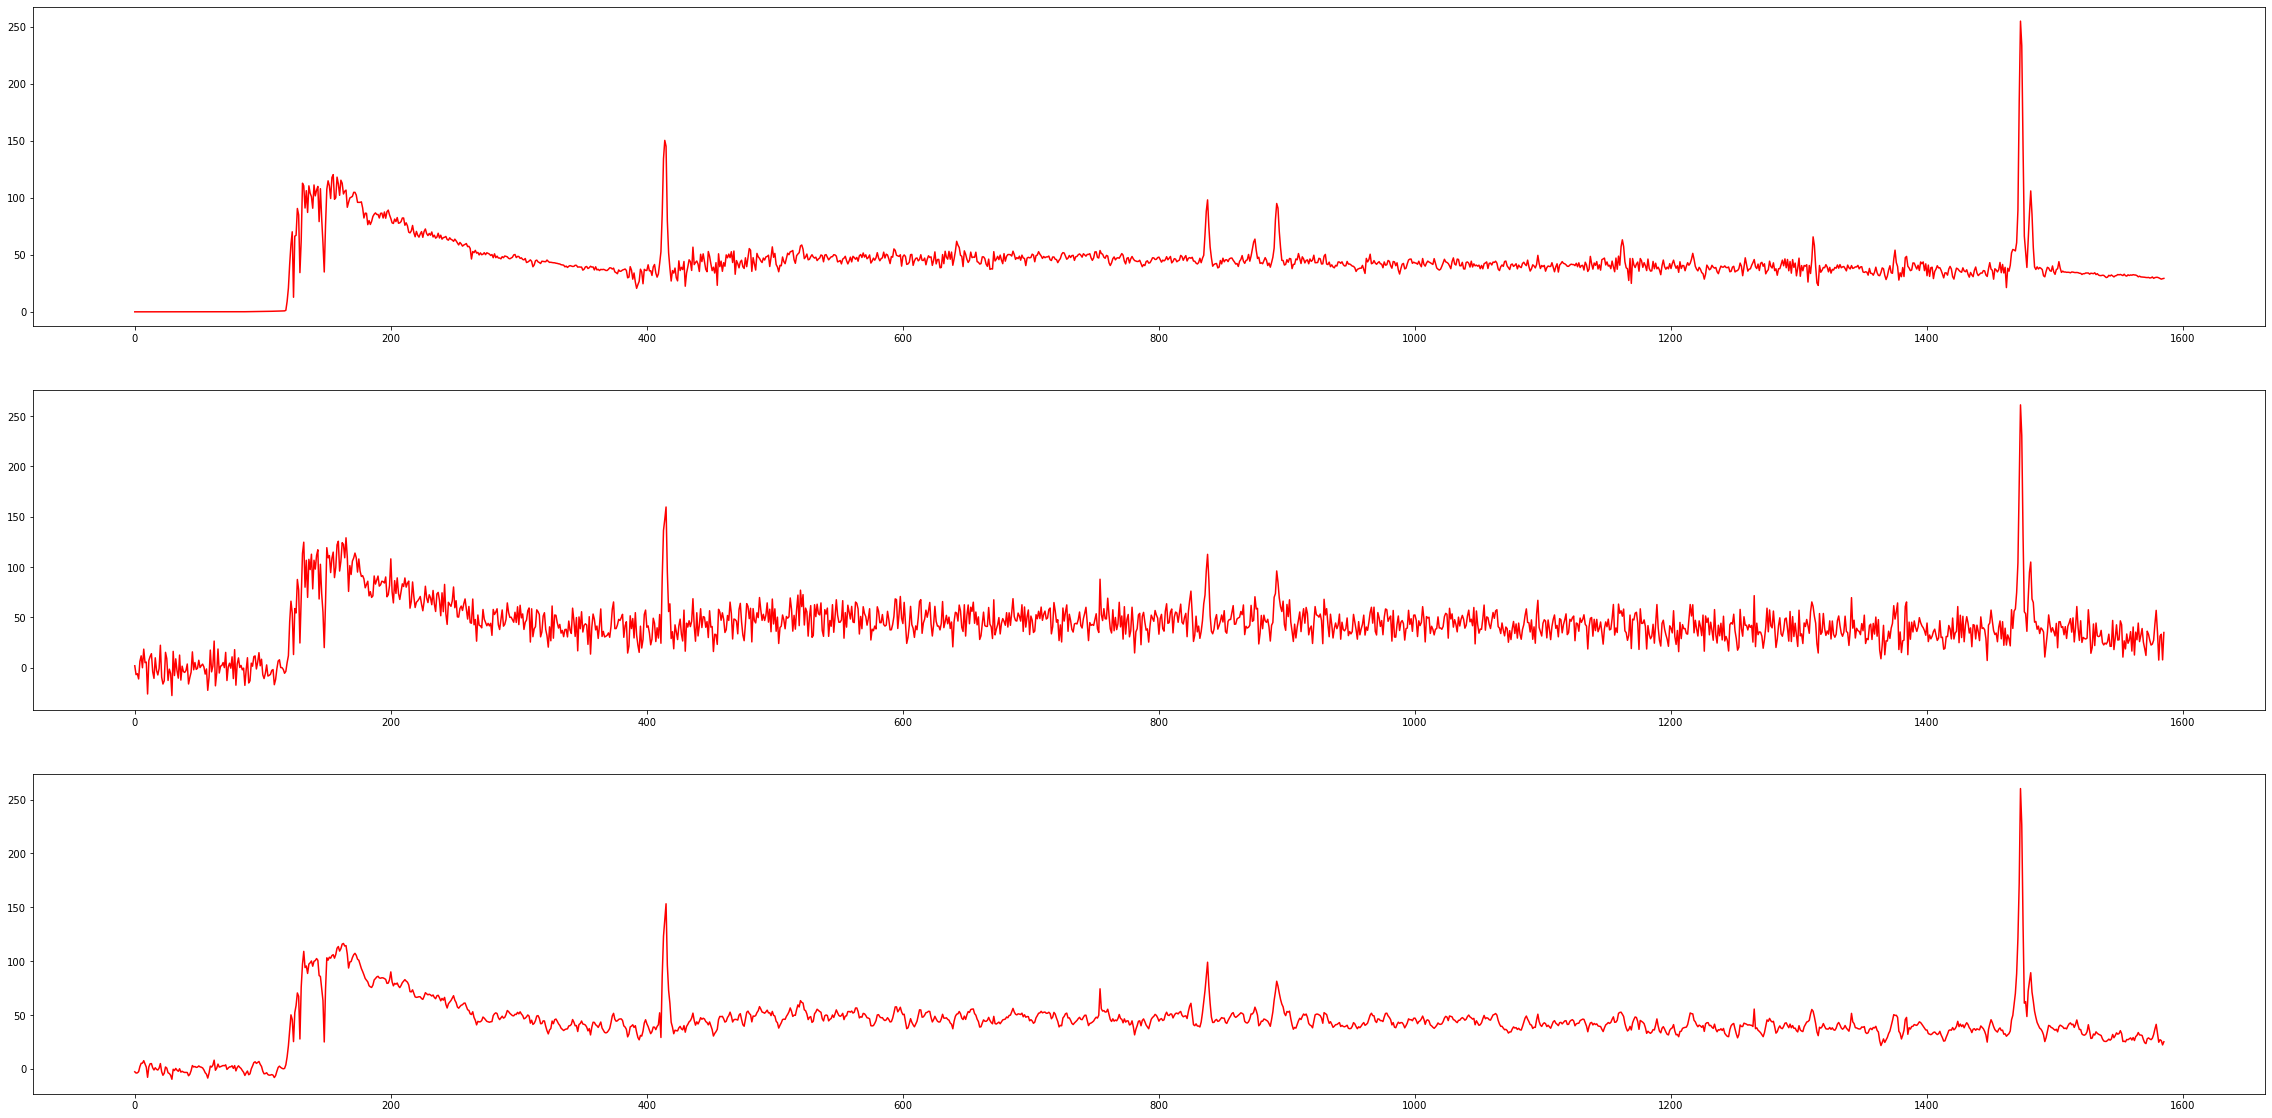

In [24]:
from matplotlib import pyplot as plt
import numpy
arp256clean = [1.400699999999999689e-22, 1.821100000000000012e-22, 2.159400000000000123e-22, 2.644499999999999981e-22, 3.291099999999999715e-22, 5.027400000000000143e-22, 7.117699999999999467e-22, 9.491600000000000001e-22, 2.974000000000000146e-21, 3.920499999999999489e-21, 4.429299999999999341e-21, 4.746100000000001336e-21, 5.589099999999999770e-21, 6.446699999999999129e-21, 7.150599999999998916e-21, 9.127199999999996874e-21, 1.060100000000000063e-20, 2.090900000000000151e-20, 4.021100000000000288e-20, 4.746100000000000884e-20, 5.627800000000000640e-20, 6.657899999999999255e-20, 7.504800000000000118e-20, 8.817399999999999686e-20, 1.017000000000000178e-19, 1.133300000000000212e-19, 1.298200000000000101e-19, 1.430000000000000046e-19, 1.528800000000000100e-19, 1.731200000000000031e-19, 2.010700000000000161e-19, 2.199600000000000125e-19, 2.456599999999999990e-19, 2.743700000000000180e-19, 2.967200000000000378e-19, 3.253400000000000345e-19, 3.893500000000000217e-19, 4.279000000000000015e-19, 4.542999999999999631e-19, 4.992800000000000504e-19, 7.750700000000000289e-19, 1.337599999999999916e-18, 1.743200000000000092e-18, 1.775600000000000012e-18, 1.964899999999999845e-18, 1.735199999999999826e-18, 2.052799999999999970e-18, 2.209699999999999882e-18, 2.297899999999999921e-18, 2.378699999999999908e-18, 2.462299999999999987e-18, 2.548799999999999873e-18, 2.537100000000000159e-18, 2.681300000000000131e-18, 2.699900000000000171e-18, 2.846700000000000037e-18, 3.057299999999999902e-18, 3.194000000000000107e-18, 3.306299999999999887e-18, 3.406700000000000138e-18, 3.502199999999999746e-18, 3.608600000000000196e-18, 3.684200000000000010e-18, 3.650400000000000236e-18, 3.822399999999999783e-18, 3.902499999999999842e-18, 3.947700000000000187e-18, 3.965899999999999828e-18, 3.984199999999999954e-18, 4.048900000000000080e-18, 4.067599999999999834e-18, 4.076999999999999953e-18, 4.105300000000000026e-18, 4.143199999999999647e-18, 4.143199999999999647e-18, 4.210599999999999766e-18, 4.757100000000001442e-18, 8.420500000000000762e-18, 8.696399999999999424e-18, 9.064400000000000856e-18, 8.858100000000000652e-18, 1.138500000000000066e-17, 1.316299999999999844e-17, 1.470099999999999904e-17, 1.426699999999999966e-17, 1.715300000000000418e-17, 1.787900000000000170e-17, 2.071800000000000023e-17, 2.373199999999999975e-17, 2.572399999999999963e-17, 2.638400000000000074e-17, 2.994599999999999766e-17, 3.201400000000000237e-17, 3.414600000000000304e-17, 3.510300000000000804e-17, 3.534600000000000282e-17, 4.449799999999999850e-17, 4.328499999999999732e-17, 5.180099999999999731e-17, 5.436799999999999913e-17, 5.679899999999998874e-17, 6.417099999999999543e-17, 6.860200000000000521e-17, 7.333999999999999956e-17, 8.004599999999999454e-17, 8.676399999999999839e-17, 9.106299999999997220e-17, 9.557400000000000004e-17, 9.961899999999999971e-17, 1.094800000000000060e-16, 9.491600000000000247e-17, 1.170399999999999997e-16, 1.219900000000000111e-16, 1.313200000000000069e-16, 1.413599999999999935e-16, 1.535799999999999978e-16, 1.623099999999999938e-16, 1.649499999999999982e-16, 2.566499999999999894e-16, 1.796099999999999741e-15, 4.095800000000000014e-15, 8.228899999999999273e-15, 1.162399999999999956e-14, 1.381500000000000065e-14, 2.513900000000000085e-15, 1.307199999999999942e-14, 1.319299999999999803e-14, 1.783799999999999995e-14, 1.672399999999999960e-14, 6.766100000000000826e-15, 1.228400000000000003e-14, 2.219899999999999962e-14, 2.174399999999999992e-14, 1.792000000000000089e-14, 2.090899999999999956e-14, 1.715300000000000085e-14, 2.174399999999999992e-14, 2.048000000000000147e-14, 1.987600000000000033e-14, 1.787899999999999884e-14, 2.189500000000000099e-14, 2.001400000000000060e-14, 2.100600000000000094e-14, 2.164399999999999908e-14, 1.557199999999999981e-14, 2.124900000000000114e-14, 1.608199999999999903e-14, 1.183999999999999991e-14, 6.876099999999999852e-15, 1.490500000000000061e-14, 2.115099999999999994e-14, 2.261200000000000061e-14, 2.174400000000000307e-14, 1.955900000000000090e-14, 2.319199999999999978e-14, 2.367800000000000018e-14, 1.942400000000000008e-14, 1.969399999999999855e-14, 2.324599999999999947e-14, 2.209699999999999914e-14, 2.010699999999999955e-14, 2.271600000000000072e-14, 2.219899999999999962e-14, 2.033899999999999858e-14, 2.081300000000000116e-14, 2.100600000000000094e-14, 1.804400000000000054e-14, 1.889500000000000115e-14, 1.964900000000000039e-14, 1.978500000000000102e-14, 1.992200000000000147e-14, 2.062200000000000417e-14, 2.062200000000000101e-14, 2.015300000000000069e-14, 1.889500000000000115e-14, 1.889500000000000115e-14, 1.889500000000000115e-14, 1.898200000000000118e-14, 1.792000000000000404e-14, 1.619299999999999787e-14, 1.703500000000000011e-14, 1.699600000000000086e-14, 1.504300000000000403e-14, 1.575199999999999879e-14, 1.507800000000000086e-14, 1.560799999999999961e-14, 1.645699999999999427e-14, 1.684000000000000069e-14, 1.707399999999999937e-14, 1.680100000000000144e-14, 1.680100000000000144e-14, 1.619300000000000103e-14, 1.699600000000000086e-14, 1.703500000000000011e-14, 1.619299999999999787e-14, 1.723199999999999917e-14, 1.615600000000000141e-14, 1.727200000000000140e-14, 1.755300000000000104e-14, 1.672399999999999960e-14, 1.611899999999999864e-14, 1.535800000000000383e-14, 1.525200000000000092e-14, 1.600799999999999980e-14, 1.557199999999999981e-14, 1.626800000000000008e-14, 1.528800000000000072e-14, 1.535799999999999752e-14, 1.557199999999999981e-14, 1.619300000000000103e-14, 1.619300000000000103e-14, 1.494000000000000059e-14, 1.535800000000000067e-14, 1.483700000000000029e-14, 1.375099999999999961e-14, 1.362500000000000032e-14, 1.397500000000000167e-14, 1.490500000000000061e-14, 1.365699999999999926e-14, 1.295200000000000062e-14, 1.387800000000000029e-14, 1.322300000000000049e-14, 1.289300000000000026e-14, 1.343799999999999945e-14, 1.384599999999999977e-14, 1.286299999999999938e-14, 1.387800000000000029e-14, 1.429999999999999965e-14, 1.349999999999999770e-14, 1.316300000000000031e-14, 1.353099999999999998e-14, 1.322300000000000049e-14, 1.378300000000000013e-14, 1.292199999999999974e-14, 1.322300000000000049e-14, 1.271600000000000073e-14, 1.289300000000000184e-14, 1.356300000000000050e-14, 1.274500000000000022e-14, 1.322300000000000049e-14, 1.254099999999999927e-14, 1.280400000000000059e-14, 1.286299999999999938e-14, 1.301199999999999923e-14, 1.248400000000000012e-14, 1.236900000000000042e-14, 1.277399999999999970e-14, 1.251199999999999979e-14, 1.239799999999999991e-14, 1.217099999999999996e-14, 1.254099999999999927e-14, 1.225600000000000036e-14, 1.189399999999999960e-14, 1.154399999999999983e-14, 1.197700000000000036e-14, 1.170800000000000171e-14, 1.134100000000000186e-14, 1.153100000000000061e-14, 1.164299999999999927e-14, 1.178400000000000058e-14, 1.125599999999999989e-14, 1.131300000000000062e-14, 1.093399999999999978e-14, 9.120099999999999239e-15, 1.040399999999999945e-14, 1.021899999999999980e-14, 1.060800000000000040e-14, 1.013499999999999922e-14, 1.025499999999999960e-14, 9.820999999999999249e-15, 1.017100000000000060e-14, 9.853299999999999399e-15, 9.949400000000001888e-15, 1.020700000000000039e-14, 9.865500000000000662e-15, 1.019399999999999959e-14, 1.008199999999999935e-14, 9.971800000000000043e-15, 9.724800000000000565e-15, 9.887900000000000395e-15, 9.339499999999999609e-15, 1.000999999999999976e-14, 9.346700000000000200e-15, 9.610999999999999386e-15, 9.287100000000000572e-15, 9.291899999999997810e-15, 9.145700000000000286e-15, 9.515699999999999593e-15, 9.346900000000000479e-15, 9.633400000000000697e-15, 9.572099999999999484e-15, 9.489399999999999935e-15, 9.233200000000000229e-15, 9.153400000000000786e-15, 9.285700000000001772e-15, 9.417299999999999414e-15, 9.821100000000000177e-15, 9.894500000000000147e-15, 9.365100000000000656e-15, 9.566299999999997694e-15, 9.549499999999999472e-15, 9.227800000000000575e-15, 9.318299999999999975e-15, 9.046000000000000658e-15, 8.968000000000000574e-15, 9.203099999999999996e-15, 8.512400000000001611e-15, 8.596000000000001629e-15, 8.758199999999999413e-15, 8.967199999999999456e-15, 8.707700000000002241e-15, 7.780800000000000531e-15, 8.095999999999999026e-15, 8.818399999999999878e-15, 8.925600000000001305e-15, 8.624999999999999536e-15, 8.511600000000000494e-15, 8.339400000000001364e-15, 8.737400000000000337e-15, 8.699800000000001462e-15, 8.664800000000001485e-15, 8.647399999999999269e-15, 8.938499999999999601e-15, 8.702499999999999711e-15, 8.531600000000001608e-15, 8.556300000000000609e-15, 8.505000000000000742e-15, 8.473500000000000131e-15, 8.461699999999999427e-15, 8.391699999999999473e-15, 8.360799999999999700e-15, 8.291799999999997987e-15, 8.258699999999999875e-15, 8.134200000000000317e-15, 8.085800000000002134e-15, 8.056200000000000233e-15, 7.769700000000000015e-15, 7.885300000000000553e-15, 7.660000000000000619e-15, 7.864099999999999340e-15, 7.978600000000000708e-15, 7.894999999999999113e-15, 7.830200000000000111e-15, 7.850800000000000485e-15, 8.036300000000000048e-15, 8.020500000000000067e-15, 7.715099999999999483e-15, 7.753300000000000774e-15, 7.720199999999999507e-15, 7.722799999999999983e-15, 7.193099999999999284e-15, 7.363100000000000074e-15, 7.748300000000000101e-15, 7.822600000000000539e-15, 7.472999999999999750e-15, 7.614499999999999387e-15, 7.866600000000000466e-15, 7.725600000000000738e-15, 7.746000000000000833e-15, 7.231399999999999926e-15, 7.769100000000000755e-15, 7.236299999999999670e-15, 7.339499999999998665e-15, 7.125400000000000176e-15, 7.327600000000000187e-15, 7.279599999999999407e-15, 7.332599999999999283e-15, 7.267800000000000281e-15, 7.137599999999999861e-15, 7.140099999999999409e-15, 7.342699999999999979e-15, 7.603299999999999520e-15, 7.570999999999999370e-15, 7.384200000000000358e-15, 7.541400000000002202e-15, 6.896100000000000177e-15, 6.756999999999999948e-15, 6.575200000000000031e-15, 7.228700000000000099e-15, 6.985699999999999897e-15, 7.036599999999998417e-15, 7.219699999999998572e-15, 7.288999999999999915e-15, 7.393099999999999378e-15, 7.144600000000000172e-15, 5.871999999999999964e-15, 5.979500000000000232e-15, 7.792500000000000307e-15, 7.200900000000000712e-15, 5.637100000000000032e-15, 6.705700000000000870e-15, 5.139799999999999623e-15, 4.054499999999999915e-15, 4.691800000000000232e-15, 5.263499999999999641e-15, 7.360999999999999507e-15, 6.896800000000000366e-15, 4.843399999999999777e-15, 7.332099999999999373e-15, 7.149299999999999637e-15, 7.138599999999999680e-15, 8.117599999999999219e-15, 7.065199999999999710e-15, 7.100799999999998948e-15, 6.279900000000000143e-15, 7.757099999999999771e-15, 8.170999999999999653e-15, 6.709700000000000146e-15, 5.987799999999999992e-15, 6.537099999999999668e-15, 8.368500000000000200e-15, 1.037200000000000051e-14, 1.689600000000000003e-14, 2.643000000000000072e-14, 2.958900000000000019e-14, 2.857799999999999697e-14, 1.569300000000000000e-14, 1.018000000000000055e-14, 7.539000000000000428e-15, 5.318300000000001242e-15, 7.122700000000001926e-15, 6.686600000000000224e-15, 7.556000000000000507e-15, 5.871799999999999685e-15, 5.343400000000000802e-15, 8.796099999999999496e-15, 7.125400000000000176e-15, 7.679399999999999317e-15, 7.294000000000000588e-15, 8.688199999999999459e-15, 4.419399999999999987e-15, 6.683599999999999978e-15, 7.754800000000000503e-15, 8.982400000000000177e-15, 8.657499999999999966e-15, 7.144300000000000542e-15, 1.116400000000000234e-14, 8.148599999999999920e-15, 8.517099999999999499e-15, 8.769599999999999559e-15, 8.226600000000000004e-15, 6.962300000000000345e-15, 9.931400000000000412e-15, 8.670199999999999561e-15, 1.000600000000000048e-14, 8.640799999999999517e-15, 7.351999999999999558e-15, 6.926600000000000180e-15, 1.040900000000000013e-14, 9.593600000000000326e-15, 8.284199999999999994e-15, 7.110800000000000293e-15, 7.704899999999999435e-15, 6.698799999999999909e-15, 8.484900000000001855e-15, 4.575599999999999645e-15, 1.001400000000000061e-14, 7.793099999999999567e-15, 8.751300000000000031e-15, 6.993200000000000118e-15, 8.480400000000001091e-15, 7.869700000000000851e-15, 9.824700000000000473e-15, 9.324600000000000097e-15, 9.962800000000000094e-15, 9.341300000000000546e-15, 1.037400000000000015e-14, 8.512100000000000404e-15, 1.049600000000000174e-14, 6.481100000000000336e-15, 8.847099999999999733e-15, 8.337199999999999869e-15, 7.592099999999999654e-15, 8.606600000000000657e-15, 8.906699999999999361e-15, 7.783200000000000728e-15, 7.487000000000000372e-15, 9.325100000000001584e-15, 7.792099999999999748e-15, 9.316800000000000246e-15, 1.091699999999999970e-14, 1.063600000000000007e-14, 6.981799999999999972e-15, 9.349900000000001514e-15, 8.325599999999999444e-15, 7.211100000000000760e-15, 1.008300000000000075e-14, 9.493400000000000789e-15, 9.224799999999999540e-15, 8.786799999999999917e-15, 8.515599999999999770e-15, 9.278699999999999884e-15, 8.944500000000000093e-15, 9.479800000000000726e-15, 9.558600000000000349e-15, 9.770399999999997993e-15, 7.822400000000000260e-15, 9.383999999999999445e-15, 1.121199999999999996e-14, 9.415400000000000705e-15, 1.008300000000000075e-14, 8.161099999999999236e-15, 7.744400000000000176e-15, 6.911900000000000946e-15, 8.025600000000000091e-15, 7.946699999999999539e-15, 9.464500000000000654e-15, 8.662699999999999340e-15, 8.311199999999999841e-15, 9.239000000000000441e-15, 1.011800000000000072e-14, 9.858799999999998404e-15, 1.036699999999999984e-14, 1.042799999999999984e-14, 1.059199999999999541e-14, 8.998299999999999508e-15, 8.372999999999999386e-15, 9.690500000000000777e-15, 9.985600000000000385e-15, 1.021400000000000070e-14, 1.137700000000000008e-14, 1.153499999999999988e-14, 1.081600000000000063e-14, 9.176899999999999689e-15, 9.458700000000000442e-15, 9.973200000000000420e-15, 8.976500000000000613e-15, 9.066000000000000194e-15, 9.528700000000000396e-15, 9.853400000000000328e-15, 9.473399999999999675e-15, 9.275900000000000706e-15, 9.434499999999999772e-15, 8.843999999999999348e-15, 9.121199999999999987e-15, 9.284799999999999726e-15, 9.811699999999999670e-15, 9.704900000000000380e-15, 8.634800000000000603e-15, 9.792700000000001530e-15, 9.875399999999999502e-15, 9.424900000000000563e-15, 8.968599999999999834e-15, 9.255300000000000332e-15, 9.500199999999999243e-15, 9.527099999999998161e-15, 9.857599999999999883e-15, 9.817799999999997935e-15, 9.607200000000000390e-15, 8.621200000000000539e-15, 8.716200000000000703e-15, 8.861899999999999895e-15, 8.275400000000000324e-15, 9.101700000000000360e-15, 9.263699999999999443e-15, 9.582200000000000181e-15, 8.829800000000000024e-15, 8.271399999999999470e-15, 8.763999999999999626e-15, 9.431599999999999666e-15, 8.621500000000000170e-15, 9.585100000000000287e-15, 9.368899999999999653e-15, 9.080800000000000356e-15, 9.383199999999999905e-15, 8.739999999999999236e-15, 9.668000000000000115e-15, 9.891699999999999392e-15, 9.381499999999999897e-15, 1.015700000000000155e-14, 9.451700000000000131e-15, 9.837100000000000437e-15, 9.155900000000000334e-15, 9.372700000000000228e-15, 9.815599999999999595e-15, 8.420899999999999237e-15, 8.769200000000000578e-15, 9.267700000000000296e-15, 8.910999999999999845e-15, 9.328700000000000302e-15, 1.020800000000000021e-14, 9.295799999999999313e-15, 8.816999999999999501e-15, 9.184100000000000279e-15, 9.321699999999999991e-15, 1.030100000000000074e-14, 9.290300000000001886e-15, 9.954399999999999405e-15, 9.808700000000001790e-15, 9.145700000000000286e-15, 8.327100000000000750e-15, 9.544099999999999818e-15, 9.432500000000000134e-15, 1.085599999999999970e-14, 1.060600000000000076e-14, 9.760600000000000082e-15, 9.666300000000000108e-15, 9.563900000000000652e-15, 9.847100000000001783e-15, 7.893100000000000403e-15, 9.538499999999999885e-15, 9.818599999999999052e-15, 9.554500000000000145e-15, 8.189100000000000480e-15, 8.266700000000000005e-15, 8.558699999999999228e-15, 9.866099999999998345e-15, 9.908300000000000490e-15, 8.019700000000000528e-15, 8.774100000000000322e-15, 9.220800000000000264e-15, 9.296400000000000151e-15, 8.797400000000000523e-15, 9.032099999999999387e-15, 9.852700000000000139e-15, 8.883900000000000647e-15, 8.867499999999999828e-15, 9.277200000000000155e-15, 8.123500000000000360e-15, 9.059999999999999702e-15, 9.677399999999999045e-15, 9.384300000000000653e-15, 9.492099999999999762e-15, 8.014800000000000783e-15, 8.861199999999999706e-15, 1.034500000000000066e-14, 8.268499999999999364e-15, 9.023200000000000366e-15, 9.056599999999999686e-15, 7.601900000000000720e-15, 7.656799999999999305e-15, 9.882300000000000462e-15, 8.306500000000000376e-15, 1.045200000000000023e-14, 9.416099999999999316e-15, 9.089600000000000025e-15, 1.043899999999999785e-14, 9.081899999999999526e-15, 1.031200000000000032e-14, 8.035099999999999950e-15, 9.133000000000000691e-15, 1.045100000000000041e-14, 1.217299999999999802e-14, 1.151500000000000035e-14, 1.110700000000000003e-14, 9.752399999999999672e-15, 9.586100000000000106e-15, 7.810099999999999646e-15, 1.052200000000000019e-14, 9.936300000000000156e-15, 9.076400000000000521e-15, 8.527099999999999267e-15, 8.885900000000000285e-15, 1.031000000000000226e-14, 9.352500000000000412e-15, 9.454300000000000607e-15, 9.402300000000000551e-15, 1.029200000000000079e-14, 8.650799999999999285e-15, 8.555100000000000511e-15, 8.246599999999999541e-15, 8.316299999999999865e-15, 9.482599999999999903e-15, 9.496199999999999966e-15, 9.180999999999999893e-15, 8.234399999999999855e-15, 7.847299999999999541e-15, 9.099199999999999235e-15, 7.324799999999999432e-15, 7.436799999999999674e-15, 7.382799999999999980e-15, 1.038399999999999992e-14, 8.779499999999999976e-15, 9.079800000000000537e-15, 9.573099999999999303e-15, 9.009899999999999933e-15, 9.790900000000000594e-15, 8.930199999999999841e-15, 8.310699999999999931e-15, 1.004699999999999937e-14, 8.743200000000002127e-15, 9.577800000000000346e-15, 9.885200000000000568e-15, 9.893099999999999770e-15, 9.854699999999999777e-15, 9.625599999999999269e-15, 1.046599999999999928e-14, 9.891800000000000320e-15, 9.052999999999999391e-15, 9.366900000000000015e-15, 9.178899999999999327e-15, 9.604300000000000283e-15, 8.909900000000000675e-15, 9.785399999999998434e-15, 9.294700000000000144e-15, 9.208100000000000669e-15, 7.984399999999999343e-15, 9.269499999999999655e-15, 9.418199999999999882e-15, 9.315300000000000518e-15, 9.384600000000000283e-15, 9.956099999999999413e-15, 9.798700000000002022e-15, 8.640199999999998679e-15, 9.689800000000000588e-15, 9.802900000000000000e-15, 1.037799999999999943e-14, 9.957099999999999232e-15, 9.650099999999999568e-15, 9.215799999999999591e-15, 9.554200000000000515e-15, 9.342699999999999346e-15, 9.475299999999999962e-15, 9.479699999999999797e-15, 9.621599999999999993e-15, 8.996299999999999870e-15, 8.858400000000000528e-15, 9.460099999999999242e-15, 9.466799999999999923e-15, 9.078499999999997932e-15, 9.017499999999999505e-15, 8.490099999999999652e-15, 8.895999999999999404e-15, 9.197000000000000153e-15, 9.916800000000000530e-15, 1.021600000000000034e-14, 1.014600000000000039e-14, 9.613199999999999304e-15, 9.078100000000000529e-15, 9.274300000000001626e-15, 9.728099999999999652e-15, 9.372499999999999948e-15, 9.698399999999999978e-15, 9.751399999999999853e-15, 8.881400000000001099e-15, 9.498300000000000533e-15, 9.569000000000000676e-15, 9.860799999999999620e-15, 9.993499999999999587e-15, 9.776999999999999323e-15, 9.437999999999999139e-15, 1.002300000000000056e-14, 9.831300000000000225e-15, 9.611399999999999945e-15, 9.907400000000000022e-15, 9.910300000000000128e-15, 1.003300000000000033e-14, 9.311299999999999664e-15, 8.887499999999999364e-15, 9.299000000000000628e-15, 1.034399999999999927e-14, 1.035600000000000025e-14, 9.386899999999999551e-15, 9.290000000000002256e-15, 1.058000000000000074e-14, 1.006399999999999945e-14, 9.949999999999999570e-15, 9.428300000000000579e-15, 9.242700000000000087e-15, 9.739700000000000077e-15, 9.627799999999999186e-15, 8.464200000000000552e-15, 7.996600000000000606e-15, 8.454100000000001433e-15, 9.172099999999999295e-15, 9.476599999999999411e-15, 8.967199999999999456e-15, 9.251100000000000776e-15, 9.341600000000000176e-15, 9.255699999999999313e-15, 9.642999999999999906e-15, 1.005399999999999968e-14, 9.777399999999999882e-15, 8.744199999999998791e-15, 8.267699999999999824e-15, 9.241700000000000268e-15, 9.354000000000000141e-15, 8.438000000000000245e-15, 9.144200000000000558e-15, 9.553599999999999676e-15, 9.138100000000000715e-15, 8.848700000000000390e-15, 8.761299999999999799e-15, 8.682900000000000733e-15, 8.710499999999999841e-15, 8.900299999999998310e-15, 8.323500000000000455e-15, 7.789199999999999642e-15, 8.138399999999999873e-15, 7.986000000000000000e-15, 8.671399999999998081e-15, 8.804399999999999256e-15, 8.411000000000000398e-15, 8.474999999999999860e-15, 8.846700000000000752e-15, 9.322199999999999900e-15, 9.307800000000000297e-15, 9.030899999999997711e-15, 9.064300000000000186e-15, 9.360000000000000633e-15, 9.444299999999997683e-15, 9.006599999999999268e-15, 8.576399999999999496e-15, 8.925700000000000656e-15, 8.792300000000000500e-15, 8.992200000000001243e-15, 9.518200000000000718e-15, 8.982100000000000547e-15, 9.253899999999999954e-15, 9.556400000000000432e-15, 8.449599999999999092e-15, 8.704600000000000277e-15, 9.178000000000000436e-15, 9.094900000000000328e-15, 8.637100000000001449e-15, 8.814699999999998655e-15, 8.930300000000000770e-15, 9.740600000000002123e-15, 9.544899999999999358e-15, 8.897099999999998574e-15, 9.369599999999999842e-15, 9.702200000000000553e-15, 8.779600000000000905e-15, 9.234900000000000237e-15, 9.361500000000000361e-15, 9.242299999999999529e-15, 9.415700000000000335e-15, 8.766100000000000192e-15, 8.735000000000000140e-15, 8.409300000000000390e-15, 8.256999999999999867e-15, 8.493499999999999667e-15, 9.249200000000000489e-15, 8.480399999999999514e-15, 9.232799999999999670e-15, 9.767400000000000113e-15, 1.337000000000000071e-14, 1.738000000000000079e-14, 1.932299999999999943e-14, 1.471100000000000101e-14, 1.117300000000000071e-14, 9.315499999999999219e-15, 7.873600000000000777e-15, 8.169999999999999834e-15, 8.293699999999999852e-15, 8.341799999999999983e-15, 7.581399999999999697e-15, 7.716799999999999491e-15, 8.864099999999999812e-15, 8.276699999999999773e-15, 9.255500000000000611e-15, 8.633299999999999296e-15, 8.971099999999999382e-15, 8.988499999999998442e-15, 8.665400000000000745e-15, 9.137799999999999507e-15, 9.261199999999999895e-15, 9.288199999999999742e-15, 8.903100000000000643e-15, 8.600499999999997659e-15, 8.242499999999999336e-15, 8.343499999999999991e-15, 7.829200000000000292e-15, 8.713199999999998090e-15, 9.035299999999999123e-15, 9.707600000000000207e-15, 8.736700000000000148e-15, 8.369400000000000668e-15, 8.860000000000001185e-15, 8.972799999999999390e-15, 9.903000000000000187e-15, 8.745700000000000097e-15, 9.649599999999999659e-15, 1.081900000000000008e-14, 1.204600000000000207e-14, 1.255100000000000062e-14, 1.063500000000000025e-14, 9.215900000000000520e-15, 9.427199999999999831e-15, 8.362799999999999338e-15, 8.463000000000000454e-15, 8.297199999999999219e-15, 8.848200000000000481e-15, 9.349699999999999657e-15, 8.912600000000000502e-15, 7.992899999999999382e-15, 8.404099999999999437e-15, 7.707499999999999912e-15, 8.510799999999999377e-15, 9.416299999999999595e-15, 1.100000000000000046e-14, 1.589299999999999852e-14, 1.869699999999999912e-14, 1.790100000000000117e-14, 1.389199999999999776e-14, 1.110199999999999936e-14, 8.888100000000000202e-15, 8.858200000000000249e-15, 8.075699999999999860e-15, 8.184899999999999347e-15, 9.000400000000000075e-15, 8.559399999999999417e-15, 9.210899999999999847e-15, 9.139299999999999236e-15, 7.456600000000000509e-15, 8.185900000000000743e-15, 8.215800000000000697e-15, 9.123600000000000183e-15, 8.984600000000000094e-15, 1.005800000000000054e-14, 9.189099999999999374e-15, 8.335899999999998842e-15, 9.492200000000002268e-15, 9.132500000000000782e-15, 8.443800000000000457e-15, 8.861199999999999706e-15, 8.967699999999999366e-15, 8.293100000000000592e-15, 9.125099999999999912e-15, 8.710099999999999282e-15, 8.922999999999999251e-15, 9.772599999999999488e-15, 8.475799999999999400e-15, 8.490599999999999561e-15, 8.508900000000000667e-15, 9.240099999999999611e-15, 9.149800000000000491e-15, 8.260800000000000442e-15, 8.281399999999999238e-15, 9.613599999999999863e-15, 9.913599999999999215e-15, 8.244599999999999903e-15, 8.155899999999999861e-15, 8.579099999999999323e-15, 7.805399999999998603e-15, 8.110299999999999278e-15, 7.740500000000001828e-15, 7.595499999999998092e-15, 8.017000000000002278e-15, 7.904399999999999620e-15, 8.612500000000000221e-15, 8.594000000000000413e-15, 8.370700000000000117e-15, 8.634499999999999395e-15, 8.147699999999999452e-15, 7.919600000000000341e-15, 7.952600000000000680e-15, 8.696800000000000427e-15, 8.240100000000000717e-15, 8.257299999999999498e-15, 8.103200000000001194e-15, 7.900299999999999416e-15, 7.846999999999999910e-15, 7.608700000000000752e-15, 6.973199999999999793e-15, 7.330200000000000664e-15, 7.438999999999999592e-15, 7.537199999999999491e-15, 7.525199999999998507e-15, 8.015400000000001621e-15, 7.345199999999999527e-15, 6.626299999999999619e-15, 9.224000000000000000e-15, 8.619300000000000252e-15, 9.000499999999997848e-15, 9.944599999999999916e-15, 8.298700000000000525e-15, 8.398200000000001452e-15, 8.840999999999999891e-15, 8.414999999999999674e-15, 8.206800000000002325e-15, 8.465299999999999722e-15, 8.655000000000000418e-15, 8.291099999999997798e-15, 8.235100000000000044e-15, 7.608500000000000472e-15, 8.607899999999998529e-15, 8.052300000000000308e-15, 8.124700000000000459e-15, 8.868500000000001225e-15, 8.722600000000000176e-15, 7.959000000000000153e-15, 7.531500000000000207e-15, 8.681599999999999707e-15, 8.628300000000000201e-15, 7.960599999999999232e-15, 8.463399999999997857e-15, 7.230800000000000666e-15, 6.523500000000001183e-15, 7.454999999999999852e-15, 8.218599999999999874e-15, 8.357800000000000243e-15, 7.406399999999999811e-15, 7.535899999999998464e-15, 8.287199999999999451e-15, 8.946499999999998154e-15, 9.094100000000000789e-15, 9.103600000000000647e-15, 8.373699999999999575e-15, 8.567800000000000106e-15, 8.441999999999997943e-15, 8.395600000000000976e-15, 8.216399999999999957e-15, 8.739100000000000345e-15, 8.160900000000000534e-15, 7.786099999999999256e-15, 9.201499999999999339e-15, 8.192099999999999937e-15, 7.883999999999999526e-15, 8.414499999999999764e-15, 8.756399999999998476e-15, 8.592600000000000035e-15, 8.469499999999999277e-15, 8.320599999999998771e-15, 8.179900000000000251e-15, 9.178699999999999047e-15, 8.386299999999999819e-15, 7.573000000000000586e-15, 7.359499999999999779e-15, 7.205499999999999249e-15, 7.360299999999999319e-15, 7.865999999999999628e-15, 8.433999999999999391e-15, 9.071600000000000127e-15, 8.634500000000000972e-15, 8.523399999999999621e-15, 8.342699999999998874e-15, 7.936199999999999861e-15, 7.444500000000000174e-15, 8.671900000000001146e-15, 9.308599999999999837e-15, 8.256900000000000517e-15, 8.067799999999999081e-15, 9.104600000000000466e-15, 9.040900000000000634e-15, 7.956500000000000605e-15, 7.938199999999999499e-15, 8.541899999999999428e-15, 7.420099999999997648e-15, 7.385900000000000366e-15, 8.526099999999999448e-15, 8.605200000000000279e-15, 8.389900000000000114e-15, 7.727300000000000746e-15, 8.742500000000000361e-15, 7.743900000000000266e-15, 8.278600000000000061e-15, 7.940200000000000715e-15, 8.061399999999999608e-15, 7.878199999999999313e-15, 8.059199999999999690e-15, 7.441399999999999788e-15, 8.005299999999999347e-15, 7.422699999999999701e-15, 8.289799999999999927e-15, 8.438000000000000245e-15, 8.617000000000000984e-15, 7.480700000000000249e-15, 8.367200000000000751e-15, 8.418500000000000618e-15, 8.087499999999998987e-15, 8.587200000000001959e-15, 8.522399999999999802e-15, 8.738900000000000066e-15, 8.401400000000001188e-15, 7.390199999999999272e-15, 7.116499999999999577e-15, 7.787900000000000193e-15, 8.088000000000002052e-15, 7.844000000000000453e-15, 8.687600000000001776e-15, 8.760099999999999700e-15, 7.934099999999999294e-15, 7.609700000000000571e-15, 7.303899999999999428e-15, 8.137600000000000333e-15, 8.252300000000000402e-15, 7.838700000000000150e-15, 8.026100000000000001e-15, 8.294199999999999762e-15, 7.416800000000000138e-15, 8.062500000000000355e-15, 7.767500000000000098e-15, 7.633199999999999473e-15, 8.335099999999999302e-15, 8.556199999999999680e-15, 8.199600000000000157e-15, 7.968799999999999641e-15, 8.922800000000000549e-15, 7.816699999999999398e-15, 7.039600000000001030e-15, 7.415899999999999670e-15, 8.116799999999999680e-15, 7.915399999999999208e-15, 7.582800000000001652e-15, 8.154800000000000692e-15, 9.750100000000000404e-15, 8.331200000000000955e-15, 7.476899999999999675e-15, 7.994599999999999390e-15, 7.800599999999999788e-15, 8.016100000000000232e-15, 7.017000000000000229e-15, 7.623999999999999245e-15, 7.909299999999999365e-15, 7.826500000000000465e-15, 7.836799999999998285e-15, 8.476999999999999498e-15, 7.714700000000000502e-15, 6.914899999999999615e-15, 7.768499999999999917e-15, 8.291000000000000025e-15, 6.864099999999999657e-15, 8.060899999999999698e-15, 8.321300000000000537e-15, 8.665700000000001953e-15, 8.368599999999999551e-15, 8.295600000000000140e-15, 8.116799999999999680e-15, 7.860999999999998955e-15, 7.853000000000000402e-15, 8.075699999999999860e-15, 8.227800000000000103e-15, 8.162699999999999893e-15, 8.155800000000000511e-15, 7.973100000000000125e-15, 8.373600000000001801e-15, 7.787900000000000193e-15, 8.458299999999999411e-15, 7.646700000000000186e-15, 7.962400000000000168e-15, 8.030099999999999277e-15, 7.213499999999999379e-15, 8.563600000000002128e-15, 8.098000000000000242e-15, 6.969199999999999728e-15, 7.362800000000000444e-15, 9.568500000000000767e-15, 8.276199999999998286e-15, 7.372199999999999374e-15, 8.426600000000000099e-15, 8.030799999999999466e-15, 8.670500000000002346e-15, 7.395600000000000504e-15, 8.115399999999999302e-15, 7.195900000000001617e-15, 9.006799999999999548e-15, 9.126500000000000290e-15, 9.277999999999999695e-15, 8.090099999999997885e-15, 8.611399999999999473e-15, 7.895000000000000690e-15, 8.034000000000000780e-15, 7.443000000000000445e-15, 8.757399999999999873e-15, 7.764300000000000361e-15, 6.917900000000000650e-15, 9.279199999999999793e-15, 7.349999999999999920e-15, 9.609999999999999567e-15, 8.049499999999999552e-15, 1.124699999999999994e-14, 1.242900000000000061e-14, 1.128499999999999937e-14, 8.629599999999999650e-15, 7.603299999999999520e-15, 7.431699999999999650e-15, 5.411900000000000238e-15, 9.213599999999999674e-15, 4.911299999999999953e-15, 9.200400000000000169e-15, 8.097200000000000702e-15, 7.643300000000000170e-15, 8.243100000000000174e-15, 8.592100000000000126e-15, 7.014800000000000311e-15, 9.200600000000000449e-15, 8.802800000000001755e-15, 7.680399999999999136e-15, 8.483299999999999620e-15, 7.950500000000000113e-15, 7.120500000000000431e-15, 9.107800000000000203e-15, 7.487299999999998424e-15, 7.033400000000000258e-15, 7.080900000000000340e-15, 8.700400000000000722e-15, 7.433000000000000677e-15, 8.393300000000001707e-15, 7.427400000000000744e-15, 7.699900000000001918e-15, 7.209299999999999823e-15, 6.409199999999998517e-15, 7.970799999999999279e-15, 8.936799999999999594e-15, 7.779100000000000523e-15, 7.348500000000000192e-15, 7.721599999999999884e-15, 7.427799999999999725e-15, 8.316799999999999774e-15, 7.473299999999999380e-15, 8.329099999999998810e-15, 8.918000000000000156e-15, 8.071599999999999655e-15, 7.523400000000000726e-15, 7.946499999999999259e-15, 6.817199999999999625e-15, 8.642199999999999895e-15, 7.482699999999999888e-15, 7.997299999999999217e-15, 7.968400000000000660e-15, 7.093499999999999795e-15, 7.869699999999999273e-15, 8.477400000000000057e-15, 8.039500000000001362e-15, 8.383000000000002309e-15, 9.078999999999999419e-15, 1.009600000000000155e-14, 9.072300000000000316e-15, 7.846399999999999072e-15, 7.360699999999999877e-15, 7.065300000000000639e-15, 7.679700000000000525e-15, 7.345699999999999436e-15, 6.773199999999999698e-15, 6.585500000000000218e-15, 5.644799999999999743e-15, 6.503500000000000069e-15, 8.061599999999999887e-15, 7.712199999999999377e-15, 7.255100000000000686e-15, 7.428399999999998985e-15, 8.026300000000000280e-15, 7.707800000000001120e-15, 7.543999999999999523e-15, 7.651199999999999371e-15, 6.915600000000001381e-15, 6.582299999999999693e-15, 7.310399999999999829e-15, 7.896599999999999770e-15, 7.719600000000000246e-15, 7.713399999999999475e-15, 7.926799999999999353e-15, 7.650800000000000391e-15, 7.624199999999999524e-15, 7.737100000000000235e-15, 6.915800000000000872e-15, 7.004400000000001562e-15, 7.710199999999999739e-15, 7.861700000000000721e-15, 6.884300000000000261e-15, 7.054800000000000172e-15, 7.127800000000000372e-15, 7.444200000000000544e-15, 8.413700000000000225e-15, 7.860500000000000623e-15, 6.232699999999999692e-15, 7.688000000000000285e-15, 9.322900000000000089e-15, 8.125299999999999719e-15, 7.028100000000000744e-15, 7.366599999999999441e-15, 7.421400000000001830e-15, 8.025500000000000740e-15, 8.484999999999999628e-15, 9.025499999999999635e-15, 7.782599999999999889e-15, 7.469999999999998715e-15, 8.239200000000000249e-15, 7.128199999999999353e-15, 8.377000000000000240e-15, 8.542000000000000357e-15, 7.861099999999999883e-15, 8.294300000000000690e-15, 6.558500000000001160e-15, 6.993300000000000258e-15, 7.280200000000000246e-15, 8.744900000000000558e-15, 7.837299999999999773e-15, 7.563899999999999708e-15, 8.456000000000000143e-15, 7.111099999999999923e-15, 7.423699999999999520e-15, 6.313999999999999652e-15, 7.430900000000000111e-15, 7.451199999999999277e-15, 8.154199999999998276e-15, 8.927200000000001962e-15, 7.947100000000000097e-15, 9.140699999999999613e-15, 7.607899999999999634e-15, 9.035399999999998474e-15, 7.082400000000000069e-15, 8.686600000000001957e-15, 6.674600000000000029e-15, 9.016299999999999406e-15, 7.674400000000001800e-15, 8.412900000000000685e-15, 6.214599999999999654e-15, 7.555300000000000318e-15, 9.270199999999999844e-15, 6.138600000000000786e-15, 7.983800000000000082e-15, 7.083600000000000167e-15, 7.996999999999999587e-15, 7.884100000000000454e-15, 8.132099999999999751e-15, 5.139700000000000272e-15, 8.001199999999999142e-15, 6.616600000000000270e-15, 8.965600000000000377e-15, 1.293700000000000018e-14, 1.145799999999999962e-14, 7.809399999999999457e-15, 4.982600000000000145e-15, 4.561300000000000182e-15, 7.998100000000000334e-15, 6.829900000000000008e-15, 7.171300000000001967e-15, 7.652200000000000768e-15, 7.609599999999998064e-15, 8.141200000000000628e-15, 7.744100000000000546e-15, 6.904499999999998499e-15, 7.676800000000000419e-15, 6.684699999999999937e-15, 7.326499999999999440e-15, 7.212900000000000118e-15, 7.662399999999999238e-15, 7.526999999999999444e-15, 8.086699999999999447e-15, 7.531299999999999928e-15, 8.148699999999999271e-15, 7.609600000000001220e-15, 7.754699999999999574e-15, 7.823400000000000079e-15, 7.472700000000000119e-15, 7.071900000000000391e-15, 8.064299999999999714e-15, 7.611700000000000209e-15, 7.396899999999999953e-15, 7.982500000000000633e-15, 7.494199999999999384e-15, 7.591300000000000114e-15, 7.756699999999999212e-15, 7.744600000000000455e-15, 8.019700000000000528e-15, 7.424400000000001287e-15, 7.741000000000000160e-15, 7.787799999999999264e-15, 6.878500000000000049e-15, 6.802799999999999233e-15, 6.916700000000001340e-15, 6.843499999999998494e-15, 6.334300000000000396e-15, 7.495599999999999762e-15, 6.649699999999999171e-15, 6.621599999999998576e-15, 6.318599999999999766e-15, 6.840599999999999965e-15, 7.707700000000000191e-15, 6.749599999999999867e-15, 6.298199999999999671e-15, 6.237700000000000365e-15, 6.783700000000000165e-15, 7.582299999999998587e-15, 7.428499999999999914e-15, 6.299599999999999260e-15, 5.572499999999999732e-15, 6.165099999999999934e-15, 7.221699999999999788e-15, 7.951799999999999562e-15, 6.739899999999999729e-15, 6.653300000000000255e-15, 9.075599999999999403e-15, 1.064699999999999965e-14, 8.501299999999999518e-15, 7.815600000000000229e-15, 5.475399999999999791e-15, 6.734099999999998728e-15, 6.065900000000000216e-15, 7.641199999999998026e-15, 6.094299999999999652e-15, 9.348499999999999558e-15, 9.564999999999999822e-15, 7.871900000000000769e-15, 7.562499999999999330e-15, 7.108699999999998149e-15, 7.221699999999999788e-15, 8.437799999999999965e-15, 8.412299999999999847e-15, 7.849499999999999458e-15, 7.390200000000000850e-15, 8.041300000000000721e-15, 7.143100000000000443e-15, 8.603399999999999343e-15, 8.297500000000000427e-15, 8.609199999999999556e-15, 7.110000000000000754e-15, 8.284100000000000643e-15, 6.231500000000000382e-15, 8.068600000000000198e-15, 6.112499999999999829e-15, 7.621900000000000256e-15, 7.692499999999999471e-15, 5.733599999999999135e-15, 6.959900000000000149e-15, 7.363800000000000263e-15, 7.952999999999999661e-15, 7.581199999999997840e-15, 7.611999999999998261e-15, 7.165099999999999618e-15, 6.544500000000001327e-15, 5.862000000000000196e-15, 6.729400000000000052e-15, 6.724099999999999749e-15, 6.329700000000000282e-15, 7.393200000000000307e-15, 7.838200000000000241e-15, 7.382600000000001278e-15, 6.068200000000001062e-15, 5.649499999999999997e-15, 6.691600000000000108e-15, 7.534699999999998366e-15, 7.428000000000000004e-15, 7.148299999999999818e-15, 6.935100000000000219e-15, 6.828300000000000140e-15, 7.591700000000000673e-15, 7.056600000000001109e-15, 6.924000000000001281e-15, 7.255699999999999946e-15, 6.485600000000000311e-15, 5.986099999999999195e-15, 6.794599999999999612e-15, 6.369499999999999075e-15, 6.071500000000000149e-15, 7.164799999999999988e-15, 7.733200000000001887e-15, 6.703999999999998495e-15, 6.257400000000000271e-15, 6.475099999999999844e-15, 6.701800000000001733e-15, 6.680699999999999872e-15, 7.117100000000000415e-15, 7.069000000000000285e-15, 6.348799999999999350e-15, 6.106899999999999107e-15, 7.412799999999999284e-15, 8.489599999999999742e-15, 7.369599999999998898e-15, 7.165299999999999897e-15, 5.635199999999999745e-15, 7.433799999999998639e-15, 7.229099999999999080e-15, 6.882399999999999974e-15, 7.273200000000001512e-15, 8.523199999999999341e-15, 6.754599999999999751e-15, 8.177500000000000055e-15, 6.705300000000000311e-15, 7.680299999999999785e-15, 4.185999999999999783e-15, 7.518300000000000703e-15, 7.016099999999999760e-15, 8.037099999999999588e-15, 1.017799999999999933e-14, 1.076099999999999953e-14, 1.067900000000000017e-14, 1.050599999999999835e-14, 1.193899999999999935e-14, 1.755800000000000013e-14, 3.621899999999999945e-14, 5.017099999999999897e-14, 4.595600000000000128e-14, 2.830599999999999887e-14, 1.306999999999999978e-14, 1.034199999999999963e-14, 7.660599999999999879e-15, 1.236800000000000060e-14, 1.692800000000000055e-14, 2.086400000000000139e-14, 1.682000000000000116e-14, 1.110400000000000057e-14, 7.738499999999999035e-15, 7.313500000000000215e-15, 7.764599999999998414e-15, 7.399800000000000059e-15, 7.644899999999999249e-15, 7.505700000000000458e-15, 7.289700000000000104e-15, 6.229000000000000046e-15, 6.040500000000000237e-15, 6.971399999999999645e-15, 7.680300000000001363e-15, 7.565099999999999807e-15, 7.104899999999997574e-15, 7.002599999999999837e-15, 7.913899999999999479e-15, 6.882500000000000903e-15, 6.469499999999999911e-15, 7.296599999999999486e-15, 7.437499999999999863e-15, 8.659900000000000162e-15, 7.552999999999999472e-15, 6.807699999999999766e-15, 7.027899999999999676e-15, 6.866499999999999854e-15, 6.881000000000000385e-15, 6.816600000000000364e-15, 6.830899999999999827e-15, 6.813899999999999748e-15, 6.734500000000001653e-15, 6.874200000000000354e-15, 6.856999999999999206e-15, 6.792800000000001042e-15, 6.775799999999998597e-15, 6.790000000000001865e-15, 6.757399999999998929e-15, 6.663400000000000163e-15, 6.646699999999999714e-15, 6.449400000000000235e-15, 6.583099999999998444e-15, 6.581699999999999644e-15, 6.702699999999999835e-15, 6.701300000000000246e-15, 6.699899999999999868e-15, 6.500999999999999732e-15, 6.666399999999998831e-15, 6.619099999999999817e-15, 6.587300000000000366e-15, 6.739399999999999820e-15, 6.434700000000001791e-15, 6.583200000000000161e-15, 6.343700000000000115e-15, 6.255399999999999055e-15, 6.254000000000000255e-15, 6.310599999999999636e-15, 6.294700000000001883e-15, 6.107800000000000364e-15, 5.912699999999999225e-15, 5.993700000000000344e-15, 6.303800000000000394e-15, 6.187400000000000316e-15, 6.359399999999999956e-15, 6.184699999999999701e-15, 6.028700000000001110e-15, 6.210600000000000378e-15, 6.266699999999999850e-15, 6.440800000000000056e-15, 6.380400000000000100e-15, 6.452800000000000251e-15, 6.348300000000000229e-15, 6.259799999999999679e-15, 6.493299999999999233e-15, 6.242600000000000109e-15, 6.169800000000000188e-15, 6.385199999999999705e-15, 6.267199999999999759e-15, 6.367600000000000365e-15, 6.322400000000000341e-15, 6.408899999999999676e-15, 6.363299999999999092e-15, 6.347200000000000270e-15, 6.244300000000000117e-15, 6.044900000000000072e-15, 6.155800000000000355e-15, 6.028199999999999623e-15, 6.013000000000001269e-15, 6.011600000000000103e-15, 5.968800000000000275e-15, 5.926400000000000217e-15, 5.911399999999999776e-15, 5.937300000000001242e-15, 5.841000000000000052e-15, 5.880100000000000234e-15, 6.015600000000000168e-15, 5.783299999999999923e-15, 5.903100000000000016e-15, 5.956300000000000170e-15, 5.954799999999999653e-15, 5.871799999999999685e-15, 5.763200000000000247e-15, 5.643699999999999784e-15, 5.720800000000000189e-15, 5.772300000000000336e-15]

clean = numpy.asarray(arp256clean,dtype=numpy.float64)
clean = (clean / clean.max()) * 255
numpy.random.seed(12431)
sig = 10  # Standard deviation of noise
noise = np.random.normal(0, sig, clean.shape)
z = clean + noise
variance = sig ** 2



cleaned = fabada(z[:],variance)
fig, (ax) = plt.subplots((3), figsize=(40,20))
ax[0].plot(clean, color="red")  
ax[1].plot(z, color="red")                     
ax[2].plot(cleaned, color="red")                     
                                   
plt.show()

0.7954639240631844
0.8294032368714812
0.8294032368714812
0.8294032368714812
0.8294032368714812
0.3950756387318966
0.8296646154831613
0.8478905387940381
0.8478905387940381
0.8478905387940381
0.8478905387940381
0.3977674414832176
0.8489166548971625
0.8415819445073569
0.8415819445073569
0.8415819445073569
0.8415819445073569
0.4484799223948147
0.8415173529022829
0.8521557923694292
0.8521557923694292
0.8521557923694292
0.8521557923694292
0.40122439250825725
0.8511427889121742
0.8514461961208563
0.8514461961208563
0.8514461961208563
0.8514461961208563
0.3691064094196909
0.8509493322774285
0.8716594366336348
0.8716594366336348
0.8716594366336348
0.8716594366336348
0.3975893052323765
0.8557563464607221
0.8692137234049286
0.8692137234049286
0.8692137234049286
0.8692137234049286
0.3926480157111689
0.8680153228627198
0.8811271414614466
0.8811271414614466
0.8811271414614466
0.8811271414614466
0.38407848681421536
0.8801261362789783
0.860301829810152
0.860301829810152
0.860301829810152
0.86030182981

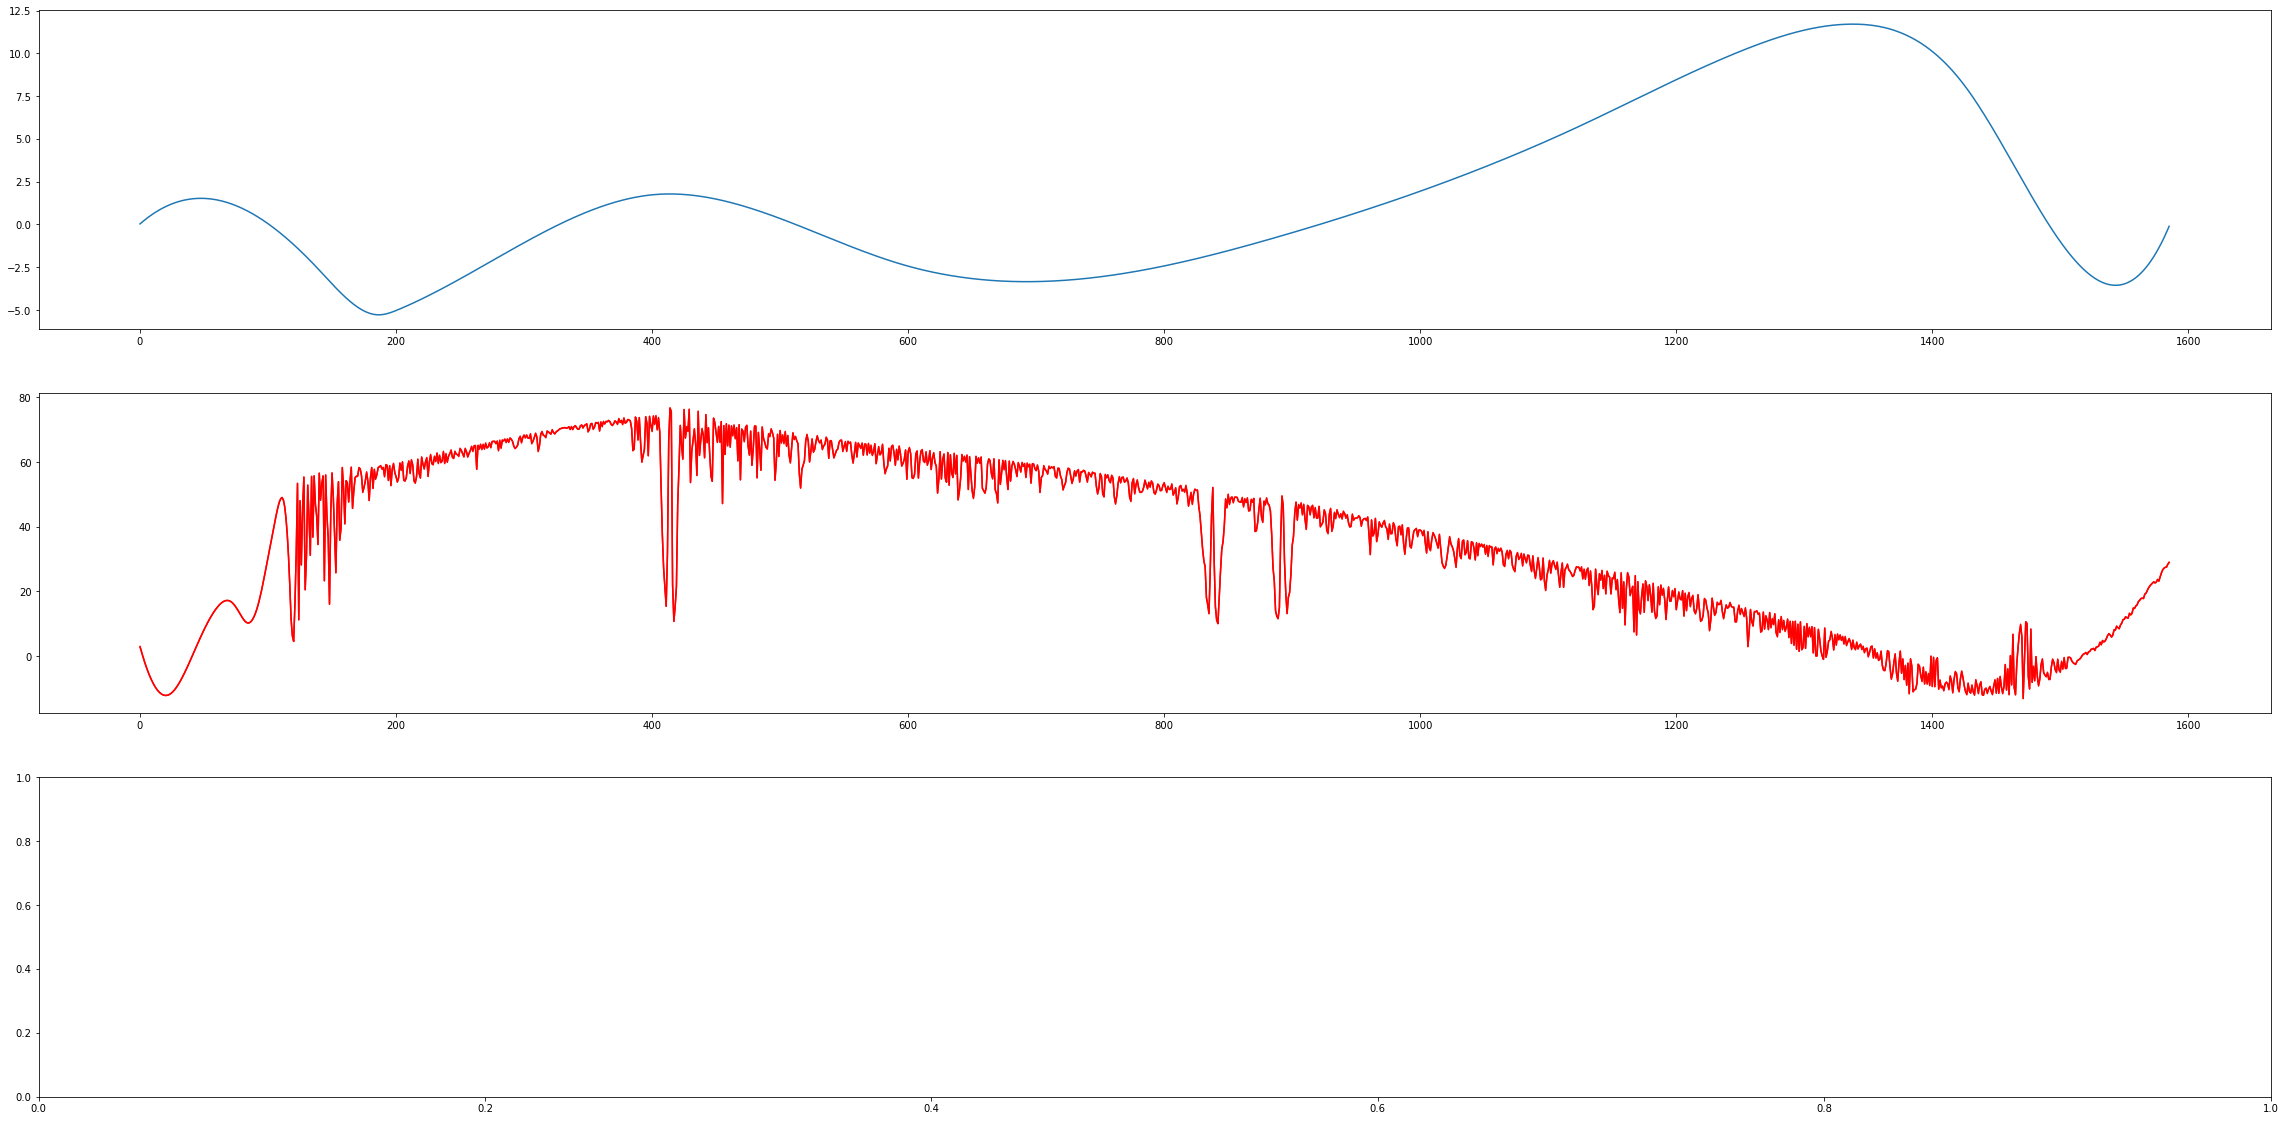

In [39]:
decomposition = numpy.asarray(XITD(clean))
print(decomposition.shape)
residue = numpy.zeros_like(clean)
residue[:] = decomposition[-1,:]
clean2 = fabada(residue[:],1)
(3887672.4127397547 * 0.9796179805338642) / 1586

fig, (ax) = plt.subplots((3), figsize=(40,20))
ax[0].plot(decomposition[2,:])
ax[1].plot(residue, color="red")                     
ax[1].plot(clean2, color="red")                     
                           
plt.show()

In [30]:
print(clean2.shape)

(1586,)


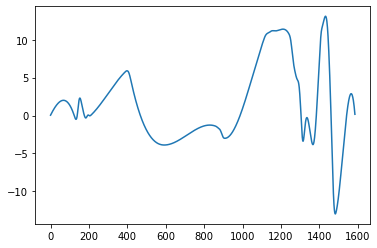

In [41]:

plt.plot(decomposition[1,:])
                    
                           
plt.show()

In [47]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
def func(r):
    plt.figure(figsize=(8,5))
    plt.plot(decomposition[r,:])
    plt.show()
    return (r)

In [51]:
y=interactive(func,r=widgets.IntSlider(min=0, max=decomposition.shape[0]-1, step=1, value=10))
display(y)

interactive(children=(IntSlider(value=10, description='r', max=163), Output()), _dom_classes=('widget-interact…

In [53]:
trends = numpy.zeros(clean2.shape)
q = decomposition[:-1,:]
for each in range(trends.shape[0]):
    trends[each] = math.fsum(q[:,each])
output = trends + clean2
    

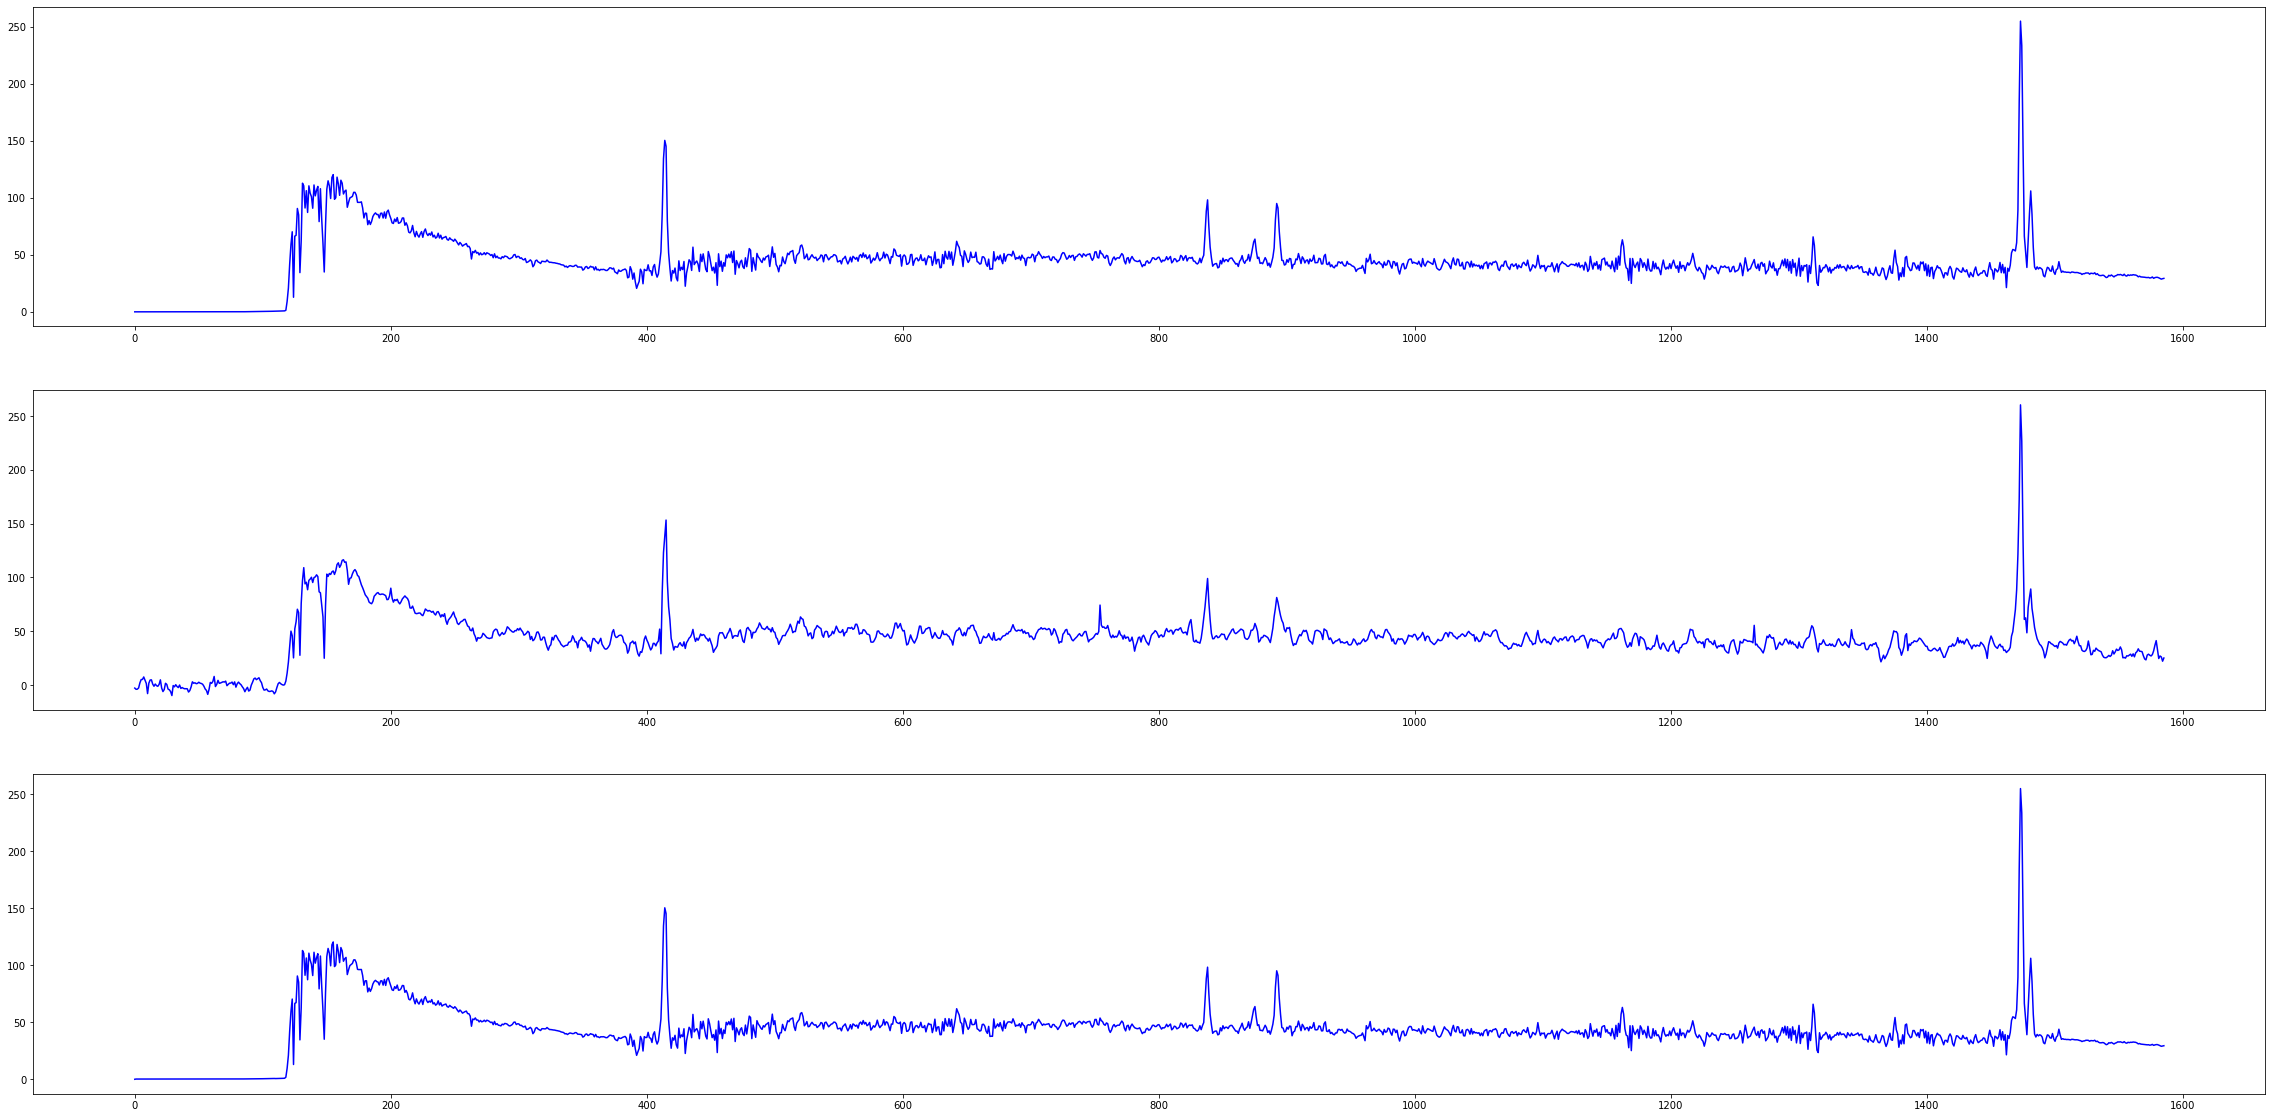

In [54]:
fig, (ax) = plt.subplots((3), figsize=(40,20))
ax[0].plot(clean, color="blue")    
ax[1].plot(cleaned, color="blue")
ax[2].plot(output, color="blue")                     
                           
plt.show()

In [58]:
def show_results(y, z, y_recover, save_fig=False):
    # PLOTTING RESULTS WITH MATPLOTLIB
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(11, 3))

    ax.plot(y, "r-", alpha=0.3, lw=1, label="Signal")

    try:
        text_noisy = "({:2.2f}/{:1.2})".format(
            PSNR(z, y, L=255), ssim(z, y, data_range=255)
        )

        text_recover = "({:2.2f}/{:1.2})".format(
            PSNR(y_recover, y, L=255), ssim(y_recover, y, data_range=255)
        )
    except:
        text_noisy = "({:2.2f})".format(PSNR(z, y, L=255))

        text_recover = "({:2.2f})".format(PSNR(y_recover, y, L=255))

    ax.plot(z, "k-", alpha=0.1, lw=1, label="Noisy " + text_noisy)
    ax.plot(y_recover, "k-", alpha=1, lw=1, label="Recover " + text_recover)
    ax.set_xlim([-1, y.size])
    ax.set_ylim([-0.01 * 255, 0.65 * 255])
    ax.set_xticks([])
    ax.set_yticks([])
    fig.legend(loc="upper center", fancybox=True, shadow=True, ncol=3)
    plt.subplots_adjust(
        top=0.97, bottom=0.0, left=0.01, right=0.99, wspace=0.0, hspace=0.00
    )

    if save_fig:
        save_path = os.path.join(os.getcwd(), "..", "src", "images")
        plt.savefig(
            os.path.join(
                save_path, "arp256_fabada_{:2.2f}dB.jpg".format(PSNR(z, y, L=255))
            ),
            dpi=300,
        )

    plt.show()

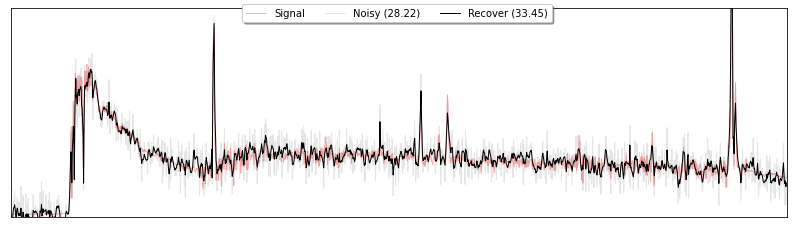

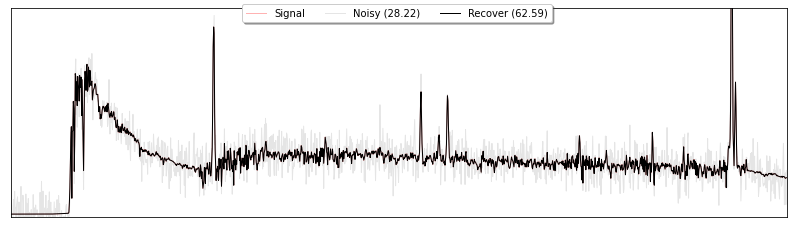

In [59]:
show_results(clean, z, cleaned)
show_results(clean, z, output)